In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b25_t1_mask_t1_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 934)
(3944610, 8)
validation
(464344, 934)
(464344, 8)
test
(574820, 934)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 934)]             0         


 dense (Dense)               (None, 1024)              957440    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1647496 (6.28 MB)


Trainable params: 1647496 (6.28 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

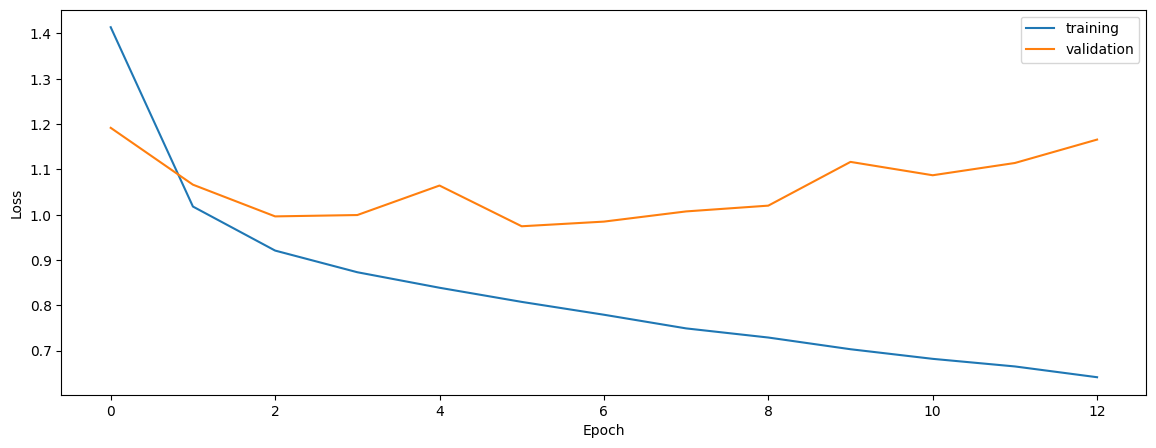

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
props1 = props
model1 = model

In [8]:
props = props.copy()
props['radiomics'] = [{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi']}]
props['binarize'] = False
props['not_connected'] = False
props['collapse_max'] = True

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_1_0_0_1_1_t1t2_normalized_e_n_e_0_0_e_0_0_connectivity_data_norm_b25_t1_mask_t1_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_06


In [9]:
gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1068345, 934)
(1068345, 1)
validation
(123115, 934)
(123115, 1)
test
(152076, 934)
(152076, 1)


In [10]:
stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 934)]             0         


 dense_5 (Dense)             (None, 1024)              957440    


 dense_6 (Dense)             (None, 512)               524800    


 dense_7 (Dense)             (None, 256)               131328    


 dense_8 (Dense)             (None, 128)               32896     


 dense_9 (Dense)             (None, 1)                 129       


Total params: 1646593 (6.28 MB)


Trainable params: 1646593 (6.28 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [11]:
if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000



  1/107 [..............................] - ETA: 2:02 - loss: 0.2228 - STD: 1.8614e-04 - MAE: 0.4614


  4/107 [>.............................] - ETA: 1s - loss: 0.2263 - STD: 7.2772e-04 - MAE: 0.4393  


  8/107 [=>............................] - ETA: 1s - loss: 0.2238 - STD: 0.0016 - MAE: 0.4473    


 11/107 [==>...........................] - ETA: 1s - loss: 0.2228 - STD: 0.0022 - MAE: 0.4425


 14/107 [==>...........................] - ETA: 1s - loss: 0.2216 - STD: 0.0028 - MAE: 0.4425


 17/107 [===>..........................] - ETA: 1s - loss: 0.2207 - STD: 0.0036 - MAE: 0.4440


 20/107 [====>.........................] - ETA: 1s - loss: 0.2200 - STD: 0.0045 - MAE: 0.4436


 23/107 [=====>........................] - ETA: 1s - loss: 0.2193 - STD: 0.0057 - MAE: 0.4423


 26/107 [======>.......................] - ETA: 1s - loss: 0.2186 - STD: 0.0074 - MAE: 0.4419


 29/107 [=======>......................] - ETA: 1s - loss: 0.2176 - STD: 0.0100 - MAE: 0.4415


 32/107 [=======>......................] - ETA: 1s - loss: 0.2167 - STD: 0.0135 - MAE: 0.4401


 35/107 [========>.....................] - ETA: 1s - loss: 0.2157 - STD: 0.0184 - MAE: 0.4386


 38/107 [=========>....................] - ETA: 1s - loss: 0.2146 - STD: 0.0247 - MAE: 0.4368


 41/107 [==========>...................] - ETA: 1s - loss: 0.2134 - STD: 0.0311 - MAE: 0.4345


 44/107 [===========>..................] - ETA: 1s - loss: 0.2122 - STD: 0.0376 - MAE: 0.4323


 47/107 [============>.................] - ETA: 1s - loss: 0.2112 - STD: 0.0434 - MAE: 0.4305


 50/107 [=============>................] - ETA: 1s - loss: 0.2102 - STD: 0.0483 - MAE: 0.4287


 53/107 [=============>................] - ETA: 0s - loss: 0.2092 - STD: 0.0540 - MAE: 0.4269


 56/107 [==============>...............] - ETA: 0s - loss: 0.2084 - STD: 0.0592 - MAE: 0.4250


 59/107 [===============>..............] - ETA: 0s - loss: 0.2076 - STD: 0.0640 - MAE: 0.4234


 62/107 [================>.............] - ETA: 0s - loss: 0.2068 - STD: 0.0681 - MAE: 0.4219


 64/107 [================>.............] - ETA: 1s - loss: 0.2063 - STD: 0.0708 - MAE: 0.4208


 68/107 [==================>...........] - ETA: 1s - loss: 0.2054 - STD: 0.0760 - MAE: 0.4189


 72/107 [===================>..........] - ETA: 0s - loss: 0.2046 - STD: 0.0807 - MAE: 0.4173


 76/107 [====================>.........] - ETA: 0s - loss: 0.2039 - STD: 0.0844 - MAE: 0.4159


 80/107 [=====================>........] - ETA: 0s - loss: 0.2033 - STD: 0.0882 - MAE: 0.4146


 84/107 [======================>.......] - ETA: 0s - loss: 0.2027 - STD: 0.0916 - MAE: 0.4134


 87/107 [=======================>......] - ETA: 0s - loss: 0.2023 - STD: 0.0937 - MAE: 0.4125


 90/107 [========================>.....] - ETA: 0s - loss: 0.2019 - STD: 0.0961 - MAE: 0.4117


 93/107 [=========================>....] - ETA: 0s - loss: 0.2014 - STD: 0.0979 - MAE: 0.4109


 96/107 [=========================>....] - ETA: 0s - loss: 0.2011 - STD: 0.0998 - MAE: 0.4103


 99/107 [==========================>...] - ETA: 0s - loss: 0.2007 - STD: 0.1015 - MAE: 0.4096


102/107 [===========================>..] - ETA: 0s - loss: 0.2003 - STD: 0.1031 - MAE: 0.4088


106/107 [============================>.] - ETA: 0s - loss: 0.1999 - STD: 0.1053 - MAE: 0.4080


107/107 [==============================] - 4s 29ms/step - loss: 0.1998 - STD: 0.1057 - MAE: 0.4078 - val_loss: 0.1876 - val_STD: 0.1372 - val_MAE: 0.3922


Epoch 2/10000



  1/107 [..............................] - ETA: 5s - loss: 0.1884 - STD: 0.1611 - MAE: 0.3901


  4/107 [>.............................] - ETA: 2s - loss: 0.1862 - STD: 0.1622 - MAE: 0.3842


  7/107 [>.............................] - ETA: 1s - loss: 0.1856 - STD: 0.1633 - MAE: 0.3828


 10/107 [=>............................] - ETA: 1s - loss: 0.1849 - STD: 0.1640 - MAE: 0.3822


 13/107 [==>...........................] - ETA: 1s - loss: 0.1843 - STD: 0.1656 - MAE: 0.3812


 16/107 [===>..........................] - ETA: 1s - loss: 0.1837 - STD: 0.1699 - MAE: 0.3793


 19/107 [====>.........................] - ETA: 1s - loss: 0.1835 - STD: 0.1730 - MAE: 0.3777


 22/107 [=====>........................] - ETA: 1s - loss: 0.1834 - STD: 0.1749 - MAE: 0.3763


 25/107 [======>.......................] - ETA: 1s - loss: 0.1834 - STD: 0.1760 - MAE: 0.3756


 28/107 [======>.......................] - ETA: 1s - loss: 0.1833 - STD: 0.1768 - MAE: 0.3757


 31/107 [=======>......................] - ETA: 1s - loss: 0.1830 - STD: 0.1768 - MAE: 0.3752


 34/107 [========>.....................] - ETA: 1s - loss: 0.1826 - STD: 0.1770 - MAE: 0.3748


 37/107 [=========>....................] - ETA: 1s - loss: 0.1822 - STD: 0.1774 - MAE: 0.3745


 40/107 [==========>...................] - ETA: 1s - loss: 0.1818 - STD: 0.1779 - MAE: 0.3738


 43/107 [===========>..................] - ETA: 1s - loss: 0.1817 - STD: 0.1791 - MAE: 0.3734


 46/107 [===========>..................] - ETA: 1s - loss: 0.1813 - STD: 0.1803 - MAE: 0.3728


 49/107 [============>.................] - ETA: 1s - loss: 0.1809 - STD: 0.1811 - MAE: 0.3720


 52/107 [=============>................] - ETA: 1s - loss: 0.1805 - STD: 0.1822 - MAE: 0.3713


 55/107 [==============>...............] - ETA: 0s - loss: 0.1802 - STD: 0.1833 - MAE: 0.3707


 58/107 [===============>..............] - ETA: 0s - loss: 0.1799 - STD: 0.1844 - MAE: 0.3700


 61/107 [================>.............] - ETA: 0s - loss: 0.1796 - STD: 0.1851 - MAE: 0.3694


 64/107 [================>.............] - ETA: 0s - loss: 0.1794 - STD: 0.1858 - MAE: 0.3690


 67/107 [=================>............] - ETA: 0s - loss: 0.1792 - STD: 0.1863 - MAE: 0.3687


 70/107 [==================>...........] - ETA: 0s - loss: 0.1790 - STD: 0.1869 - MAE: 0.3684


 73/107 [===================>..........] - ETA: 0s - loss: 0.1789 - STD: 0.1875 - MAE: 0.3682


 76/107 [====================>.........] - ETA: 0s - loss: 0.1787 - STD: 0.1880 - MAE: 0.3677


 79/107 [=====================>........] - ETA: 0s - loss: 0.1785 - STD: 0.1886 - MAE: 0.3674


 82/107 [=====================>........] - ETA: 0s - loss: 0.1783 - STD: 0.1891 - MAE: 0.3670


 85/107 [======================>.......] - ETA: 0s - loss: 0.1782 - STD: 0.1895 - MAE: 0.3668


 88/107 [=======================>......] - ETA: 0s - loss: 0.1779 - STD: 0.1901 - MAE: 0.3664


 91/107 [========================>.....] - ETA: 0s - loss: 0.1778 - STD: 0.1906 - MAE: 0.3660


 94/107 [=========================>....] - ETA: 0s - loss: 0.1776 - STD: 0.1911 - MAE: 0.3657


 97/107 [==========================>...] - ETA: 0s - loss: 0.1774 - STD: 0.1915 - MAE: 0.3654


100/107 [===========================>..] - ETA: 0s - loss: 0.1772 - STD: 0.1919 - MAE: 0.3651


103/107 [===========================>..] - ETA: 0s - loss: 0.1770 - STD: 0.1925 - MAE: 0.3648


106/107 [============================>.] - ETA: 0s - loss: 0.1768 - STD: 0.1931 - MAE: 0.3644


107/107 [==============================] - 2s 22ms/step - loss: 0.1767 - STD: 0.1933 - MAE: 0.3643 - val_loss: 0.1665 - val_STD: 0.1807 - val_MAE: 0.3448


Epoch 3/10000



  1/107 [..............................] - ETA: 5s - loss: 0.1723 - STD: 0.2084 - MAE: 0.3511


  4/107 [>.............................] - ETA: 2s - loss: 0.1718 - STD: 0.2094 - MAE: 0.3532


  7/107 [>.............................] - ETA: 1s - loss: 0.1721 - STD: 0.2072 - MAE: 0.3537


 10/107 [=>............................] - ETA: 1s - loss: 0.1732 - STD: 0.2066 - MAE: 0.3546


 13/107 [==>...........................] - ETA: 1s - loss: 0.1740 - STD: 0.2068 - MAE: 0.3550


 16/107 [===>..........................] - ETA: 1s - loss: 0.1737 - STD: 0.2064 - MAE: 0.3557


 19/107 [====>.........................] - ETA: 1s - loss: 0.1732 - STD: 0.2050 - MAE: 0.3562


 22/107 [=====>........................] - ETA: 1s - loss: 0.1726 - STD: 0.2042 - MAE: 0.3560


 25/107 [======>.......................] - ETA: 1s - loss: 0.1726 - STD: 0.2041 - MAE: 0.3561


 28/107 [======>.......................] - ETA: 1s - loss: 0.1723 - STD: 0.2050 - MAE: 0.3556


 31/107 [=======>......................] - ETA: 1s - loss: 0.1719 - STD: 0.2062 - MAE: 0.3549


 34/107 [========>.....................] - ETA: 1s - loss: 0.1717 - STD: 0.2073 - MAE: 0.3542


 37/107 [=========>....................] - ETA: 1s - loss: 0.1713 - STD: 0.2078 - MAE: 0.3536


 40/107 [==========>...................] - ETA: 1s - loss: 0.1710 - STD: 0.2086 - MAE: 0.3531


 43/107 [===========>..................] - ETA: 1s - loss: 0.1711 - STD: 0.2093 - MAE: 0.3530


 46/107 [===========>..................] - ETA: 1s - loss: 0.1709 - STD: 0.2096 - MAE: 0.3527


 49/107 [============>.................] - ETA: 1s - loss: 0.1709 - STD: 0.2096 - MAE: 0.3526


 52/107 [=============>................] - ETA: 1s - loss: 0.1712 - STD: 0.2094 - MAE: 0.3527


 55/107 [==============>...............] - ETA: 0s - loss: 0.1713 - STD: 0.2094 - MAE: 0.3528


 58/107 [===============>..............] - ETA: 0s - loss: 0.1712 - STD: 0.2092 - MAE: 0.3529


 61/107 [================>.............] - ETA: 0s - loss: 0.1712 - STD: 0.2087 - MAE: 0.3530


 64/107 [================>.............] - ETA: 0s - loss: 0.1710 - STD: 0.2084 - MAE: 0.3530


 67/107 [=================>............] - ETA: 0s - loss: 0.1709 - STD: 0.2085 - MAE: 0.3528


 70/107 [==================>...........] - ETA: 0s - loss: 0.1708 - STD: 0.2089 - MAE: 0.3526


 73/107 [===================>..........] - ETA: 0s - loss: 0.1706 - STD: 0.2095 - MAE: 0.3522


 76/107 [====================>.........] - ETA: 0s - loss: 0.1704 - STD: 0.2100 - MAE: 0.3519


 79/107 [=====================>........] - ETA: 0s - loss: 0.1702 - STD: 0.2104 - MAE: 0.3516


 82/107 [=====================>........] - ETA: 0s - loss: 0.1701 - STD: 0.2107 - MAE: 0.3514


 85/107 [======================>.......] - ETA: 0s - loss: 0.1700 - STD: 0.2111 - MAE: 0.3512


 88/107 [=======================>......] - ETA: 0s - loss: 0.1699 - STD: 0.2115 - MAE: 0.3510


 91/107 [========================>.....] - ETA: 0s - loss: 0.1697 - STD: 0.2119 - MAE: 0.3507


 94/107 [=========================>....] - ETA: 0s - loss: 0.1696 - STD: 0.2122 - MAE: 0.3505


 97/107 [==========================>...] - ETA: 0s - loss: 0.1695 - STD: 0.2125 - MAE: 0.3504


100/107 [===========================>..] - ETA: 0s - loss: 0.1694 - STD: 0.2127 - MAE: 0.3502


103/107 [===========================>..] - ETA: 0s - loss: 0.1692 - STD: 0.2131 - MAE: 0.3499


106/107 [============================>.] - ETA: 0s - loss: 0.1692 - STD: 0.2134 - MAE: 0.3497


107/107 [==============================] - 2s 21ms/step - loss: 0.1692 - STD: 0.2135 - MAE: 0.3497 - val_loss: 0.1643 - val_STD: 0.1991 - val_MAE: 0.3428


Epoch 4/10000



  1/107 [..............................] - ETA: 4s - loss: 0.1647 - STD: 0.2252 - MAE: 0.3431


  4/107 [>.............................] - ETA: 1s - loss: 0.1658 - STD: 0.2231 - MAE: 0.3440


  8/107 [=>............................] - ETA: 1s - loss: 0.1662 - STD: 0.2204 - MAE: 0.3443


 12/107 [==>...........................] - ETA: 1s - loss: 0.1662 - STD: 0.2197 - MAE: 0.3444


 16/107 [===>..........................] - ETA: 1s - loss: 0.1669 - STD: 0.2195 - MAE: 0.3451


 20/107 [====>.........................] - ETA: 1s - loss: 0.1683 - STD: 0.2177 - MAE: 0.3457


 24/107 [=====>........................] - ETA: 1s - loss: 0.1683 - STD: 0.2163 - MAE: 0.3463


 27/107 [======>.......................] - ETA: 1s - loss: 0.1680 - STD: 0.2152 - MAE: 0.3467


 30/107 [=======>......................] - ETA: 1s - loss: 0.1680 - STD: 0.2146 - MAE: 0.3471


 33/107 [========>.....................] - ETA: 1s - loss: 0.1679 - STD: 0.2147 - MAE: 0.3470


 36/107 [=========>....................] - ETA: 1s - loss: 0.1676 - STD: 0.2157 - MAE: 0.3464


 39/107 [=========>....................] - ETA: 1s - loss: 0.1674 - STD: 0.2165 - MAE: 0.3461


 42/107 [==========>...................] - ETA: 1s - loss: 0.1673 - STD: 0.2171 - MAE: 0.3458


 45/107 [===========>..................] - ETA: 1s - loss: 0.1671 - STD: 0.2178 - MAE: 0.3455


 48/107 [============>.................] - ETA: 1s - loss: 0.1668 - STD: 0.2186 - MAE: 0.3450


 51/107 [=============>................] - ETA: 1s - loss: 0.1665 - STD: 0.2193 - MAE: 0.3445


 54/107 [==============>...............] - ETA: 0s - loss: 0.1663 - STD: 0.2197 - MAE: 0.3442


 57/107 [==============>...............] - ETA: 0s - loss: 0.1662 - STD: 0.2202 - MAE: 0.3440


 61/107 [================>.............] - ETA: 0s - loss: 0.1662 - STD: 0.2205 - MAE: 0.3438


 64/107 [================>.............] - ETA: 0s - loss: 0.1662 - STD: 0.2206 - MAE: 0.3437


 67/107 [=================>............] - ETA: 0s - loss: 0.1662 - STD: 0.2207 - MAE: 0.3436


 70/107 [==================>...........] - ETA: 0s - loss: 0.1663 - STD: 0.2207 - MAE: 0.3436


 73/107 [===================>..........] - ETA: 0s - loss: 0.1663 - STD: 0.2206 - MAE: 0.3436


 76/107 [====================>.........] - ETA: 0s - loss: 0.1662 - STD: 0.2204 - MAE: 0.3436


 79/107 [=====================>........] - ETA: 0s - loss: 0.1662 - STD: 0.2201 - MAE: 0.3437


 82/107 [=====================>........] - ETA: 0s - loss: 0.1661 - STD: 0.2200 - MAE: 0.3437


 85/107 [======================>.......] - ETA: 0s - loss: 0.1660 - STD: 0.2200 - MAE: 0.3436


 88/107 [=======================>......] - ETA: 0s - loss: 0.1659 - STD: 0.2203 - MAE: 0.3434


 91/107 [========================>.....] - ETA: 0s - loss: 0.1658 - STD: 0.2207 - MAE: 0.3432


 94/107 [=========================>....] - ETA: 0s - loss: 0.1657 - STD: 0.2210 - MAE: 0.3430


 97/107 [==========================>...] - ETA: 0s - loss: 0.1656 - STD: 0.2213 - MAE: 0.3429


100/107 [===========================>..] - ETA: 0s - loss: 0.1655 - STD: 0.2216 - MAE: 0.3427


103/107 [===========================>..] - ETA: 0s - loss: 0.1654 - STD: 0.2219 - MAE: 0.3424


106/107 [============================>.] - ETA: 0s - loss: 0.1653 - STD: 0.2221 - MAE: 0.3423


107/107 [==============================] - 2s 21ms/step - loss: 0.1653 - STD: 0.2222 - MAE: 0.3422 - val_loss: 0.1602 - val_STD: 0.1917 - val_MAE: 0.3307


Epoch 5/10000



  1/107 [..............................] - ETA: 4s - loss: 0.1669 - STD: 0.2192 - MAE: 0.3381


  4/107 [>.............................] - ETA: 1s - loss: 0.1647 - STD: 0.2268 - MAE: 0.3391


  7/107 [>.............................] - ETA: 1s - loss: 0.1642 - STD: 0.2260 - MAE: 0.3391


 10/107 [=>............................] - ETA: 1s - loss: 0.1644 - STD: 0.2264 - MAE: 0.3392


 13/107 [==>...........................] - ETA: 1s - loss: 0.1648 - STD: 0.2260 - MAE: 0.3396


 16/107 [===>..........................] - ETA: 1s - loss: 0.1645 - STD: 0.2262 - MAE: 0.3393


 19/107 [====>.........................] - ETA: 1s - loss: 0.1639 - STD: 0.2260 - MAE: 0.3390


 22/107 [=====>........................] - ETA: 1s - loss: 0.1637 - STD: 0.2255 - MAE: 0.3393


 25/107 [======>.......................] - ETA: 1s - loss: 0.1634 - STD: 0.2252 - MAE: 0.3391


 28/107 [======>.......................] - ETA: 1s - loss: 0.1632 - STD: 0.2257 - MAE: 0.3389


 31/107 [=======>......................] - ETA: 1s - loss: 0.1631 - STD: 0.2269 - MAE: 0.3385


 34/107 [========>.....................] - ETA: 1s - loss: 0.1627 - STD: 0.2277 - MAE: 0.3378


 37/107 [=========>....................] - ETA: 1s - loss: 0.1626 - STD: 0.2282 - MAE: 0.3377


 40/107 [==========>...................] - ETA: 1s - loss: 0.1624 - STD: 0.2289 - MAE: 0.3373


 43/107 [===========>..................] - ETA: 1s - loss: 0.1624 - STD: 0.2296 - MAE: 0.3370


 46/107 [===========>..................] - ETA: 1s - loss: 0.1622 - STD: 0.2300 - MAE: 0.3368


 49/107 [============>.................] - ETA: 1s - loss: 0.1621 - STD: 0.2301 - MAE: 0.3366


 52/107 [=============>................] - ETA: 1s - loss: 0.1621 - STD: 0.2305 - MAE: 0.3364


 55/107 [==============>...............] - ETA: 0s - loss: 0.1622 - STD: 0.2304 - MAE: 0.3363


 58/107 [===============>..............] - ETA: 0s - loss: 0.1623 - STD: 0.2302 - MAE: 0.3364


 61/107 [================>.............] - ETA: 0s - loss: 0.1627 - STD: 0.2301 - MAE: 0.3367


 64/107 [================>.............] - ETA: 0s - loss: 0.1631 - STD: 0.2299 - MAE: 0.3370


 67/107 [=================>............] - ETA: 0s - loss: 0.1633 - STD: 0.2292 - MAE: 0.3374


 70/107 [==================>...........] - ETA: 0s - loss: 0.1635 - STD: 0.2278 - MAE: 0.3378


 73/107 [===================>..........] - ETA: 0s - loss: 0.1636 - STD: 0.2268 - MAE: 0.3382


 76/107 [====================>.........] - ETA: 0s - loss: 0.1636 - STD: 0.2265 - MAE: 0.3384


 79/107 [=====================>........] - ETA: 0s - loss: 0.1637 - STD: 0.2261 - MAE: 0.3386


 82/107 [=====================>........] - ETA: 0s - loss: 0.1637 - STD: 0.2258 - MAE: 0.3386


 85/107 [======================>.......] - ETA: 0s - loss: 0.1637 - STD: 0.2257 - MAE: 0.3387


 88/107 [=======================>......] - ETA: 0s - loss: 0.1636 - STD: 0.2261 - MAE: 0.3385


 91/107 [========================>.....] - ETA: 0s - loss: 0.1635 - STD: 0.2265 - MAE: 0.3383


 94/107 [=========================>....] - ETA: 0s - loss: 0.1634 - STD: 0.2267 - MAE: 0.3381


 97/107 [==========================>...] - ETA: 0s - loss: 0.1633 - STD: 0.2269 - MAE: 0.3380


100/107 [===========================>..] - ETA: 0s - loss: 0.1633 - STD: 0.2272 - MAE: 0.3379


103/107 [===========================>..] - ETA: 0s - loss: 0.1631 - STD: 0.2275 - MAE: 0.3376


106/107 [============================>.] - ETA: 0s - loss: 0.1630 - STD: 0.2277 - MAE: 0.3375


107/107 [==============================] - 2s 21ms/step - loss: 0.1629 - STD: 0.2279 - MAE: 0.3374 - val_loss: 0.1598 - val_STD: 0.2111 - val_MAE: 0.3319


Epoch 6/10000



  1/107 [..............................] - ETA: 5s - loss: 0.1579 - STD: 0.2418 - MAE: 0.3298


  4/107 [>.............................] - ETA: 2s - loss: 0.1583 - STD: 0.2388 - MAE: 0.3303


  7/107 [>.............................] - ETA: 1s - loss: 0.1599 - STD: 0.2381 - MAE: 0.3318


 10/107 [=>............................] - ETA: 1s - loss: 0.1601 - STD: 0.2374 - MAE: 0.3322


 13/107 [==>...........................] - ETA: 1s - loss: 0.1606 - STD: 0.2374 - MAE: 0.3326


 16/107 [===>..........................] - ETA: 1s - loss: 0.1607 - STD: 0.2370 - MAE: 0.3329


 19/107 [====>.........................] - ETA: 1s - loss: 0.1605 - STD: 0.2366 - MAE: 0.3330


 22/107 [=====>........................] - ETA: 1s - loss: 0.1602 - STD: 0.2366 - MAE: 0.3327


 25/107 [======>.......................] - ETA: 1s - loss: 0.1600 - STD: 0.2372 - MAE: 0.3323


 28/107 [======>.......................] - ETA: 1s - loss: 0.1598 - STD: 0.2376 - MAE: 0.3319


 31/107 [=======>......................] - ETA: 1s - loss: 0.1597 - STD: 0.2373 - MAE: 0.3318


 34/107 [========>.....................] - ETA: 1s - loss: 0.1597 - STD: 0.2374 - MAE: 0.3318


 37/107 [=========>....................] - ETA: 1s - loss: 0.1596 - STD: 0.2373 - MAE: 0.3318


 40/107 [==========>...................] - ETA: 1s - loss: 0.1596 - STD: 0.2373 - MAE: 0.3318


 43/107 [===========>..................] - ETA: 1s - loss: 0.1595 - STD: 0.2375 - MAE: 0.3316


 46/107 [===========>..................] - ETA: 1s - loss: 0.1595 - STD: 0.2378 - MAE: 0.3315


 49/107 [============>.................] - ETA: 1s - loss: 0.1598 - STD: 0.2375 - MAE: 0.3317


 52/107 [=============>................] - ETA: 1s - loss: 0.1602 - STD: 0.2371 - MAE: 0.3321


 55/107 [==============>...............] - ETA: 0s - loss: 0.1607 - STD: 0.2363 - MAE: 0.3323


 58/107 [===============>..............] - ETA: 0s - loss: 0.1607 - STD: 0.2355 - MAE: 0.3325


 61/107 [================>.............] - ETA: 0s - loss: 0.1609 - STD: 0.2344 - MAE: 0.3330


 64/107 [================>.............] - ETA: 0s - loss: 0.1610 - STD: 0.2336 - MAE: 0.3335


 67/107 [=================>............] - ETA: 0s - loss: 0.1609 - STD: 0.2332 - MAE: 0.3336


 70/107 [==================>...........] - ETA: 0s - loss: 0.1608 - STD: 0.2330 - MAE: 0.3336


 73/107 [===================>..........] - ETA: 0s - loss: 0.1608 - STD: 0.2329 - MAE: 0.3335


 76/107 [====================>.........] - ETA: 0s - loss: 0.1608 - STD: 0.2331 - MAE: 0.3334


 79/107 [=====================>........] - ETA: 0s - loss: 0.1608 - STD: 0.2336 - MAE: 0.3332


 82/107 [=====================>........] - ETA: 0s - loss: 0.1606 - STD: 0.2340 - MAE: 0.3330


 85/107 [======================>.......] - ETA: 0s - loss: 0.1606 - STD: 0.2342 - MAE: 0.3329


 88/107 [=======================>......] - ETA: 0s - loss: 0.1605 - STD: 0.2345 - MAE: 0.3327


 91/107 [========================>.....] - ETA: 0s - loss: 0.1604 - STD: 0.2348 - MAE: 0.3326


 94/107 [=========================>....] - ETA: 0s - loss: 0.1603 - STD: 0.2349 - MAE: 0.3325


 97/107 [==========================>...] - ETA: 0s - loss: 0.1602 - STD: 0.2349 - MAE: 0.3324


100/107 [===========================>..] - ETA: 0s - loss: 0.1602 - STD: 0.2351 - MAE: 0.3323


103/107 [===========================>..] - ETA: 0s - loss: 0.1601 - STD: 0.2353 - MAE: 0.3322


107/107 [==============================] - ETA: 0s - loss: 0.1600 - STD: 0.2354 - MAE: 0.3321


107/107 [==============================] - 2s 21ms/step - loss: 0.1600 - STD: 0.2354 - MAE: 0.3321 - val_loss: 0.1566 - val_STD: 0.2105 - val_MAE: 0.3268


Epoch 7/10000



  1/107 [..............................] - ETA: 5s - loss: 0.1577 - STD: 0.2392 - MAE: 0.3274


  4/107 [>.............................] - ETA: 2s - loss: 0.1574 - STD: 0.2401 - MAE: 0.3281


  7/107 [>.............................] - ETA: 1s - loss: 0.1574 - STD: 0.2406 - MAE: 0.3281


 10/107 [=>............................] - ETA: 1s - loss: 0.1584 - STD: 0.2412 - MAE: 0.3287


 13/107 [==>...........................] - ETA: 1s - loss: 0.1586 - STD: 0.2411 - MAE: 0.3287


 16/107 [===>..........................] - ETA: 1s - loss: 0.1584 - STD: 0.2407 - MAE: 0.3287


 19/107 [====>.........................] - ETA: 1s - loss: 0.1584 - STD: 0.2402 - MAE: 0.3290


 22/107 [=====>........................] - ETA: 1s - loss: 0.1587 - STD: 0.2400 - MAE: 0.3293


 25/107 [======>.......................] - ETA: 1s - loss: 0.1587 - STD: 0.2399 - MAE: 0.3294


 28/107 [======>.......................] - ETA: 1s - loss: 0.1586 - STD: 0.2399 - MAE: 0.3293


 31/107 [=======>......................] - ETA: 1s - loss: 0.1586 - STD: 0.2399 - MAE: 0.3294


 34/107 [========>.....................] - ETA: 1s - loss: 0.1584 - STD: 0.2399 - MAE: 0.3292


 37/107 [=========>....................] - ETA: 1s - loss: 0.1583 - STD: 0.2401 - MAE: 0.3291


 40/107 [==========>...................] - ETA: 1s - loss: 0.1582 - STD: 0.2401 - MAE: 0.3289


 43/107 [===========>..................] - ETA: 1s - loss: 0.1582 - STD: 0.2403 - MAE: 0.3288


 46/107 [===========>..................] - ETA: 1s - loss: 0.1580 - STD: 0.2404 - MAE: 0.3286


 49/107 [============>.................] - ETA: 1s - loss: 0.1580 - STD: 0.2407 - MAE: 0.3284


 52/107 [=============>................] - ETA: 1s - loss: 0.1580 - STD: 0.2409 - MAE: 0.3284


 55/107 [==============>...............] - ETA: 0s - loss: 0.1580 - STD: 0.2410 - MAE: 0.3284


 58/107 [===============>..............] - ETA: 0s - loss: 0.1580 - STD: 0.2410 - MAE: 0.3284


 61/107 [================>.............] - ETA: 0s - loss: 0.1580 - STD: 0.2410 - MAE: 0.3284


 64/107 [================>.............] - ETA: 0s - loss: 0.1579 - STD: 0.2409 - MAE: 0.3284


 67/107 [=================>............] - ETA: 0s - loss: 0.1577 - STD: 0.2410 - MAE: 0.3282


 70/107 [==================>...........] - ETA: 0s - loss: 0.1577 - STD: 0.2413 - MAE: 0.3280


 73/107 [===================>..........] - ETA: 0s - loss: 0.1576 - STD: 0.2413 - MAE: 0.3279


 77/107 [====================>.........] - ETA: 0s - loss: 0.1576 - STD: 0.2414 - MAE: 0.3278


 80/107 [=====================>........] - ETA: 0s - loss: 0.1576 - STD: 0.2417 - MAE: 0.3276


 83/107 [======================>.......] - ETA: 0s - loss: 0.1575 - STD: 0.2419 - MAE: 0.3275


 86/107 [=======================>......] - ETA: 0s - loss: 0.1575 - STD: 0.2419 - MAE: 0.3275


 89/107 [=======================>......] - ETA: 0s - loss: 0.1575 - STD: 0.2419 - MAE: 0.3274


 92/107 [========================>.....] - ETA: 0s - loss: 0.1575 - STD: 0.2417 - MAE: 0.3274


 95/107 [=========================>....] - ETA: 0s - loss: 0.1575 - STD: 0.2416 - MAE: 0.3275


 98/107 [==========================>...] - ETA: 0s - loss: 0.1575 - STD: 0.2415 - MAE: 0.3275


101/107 [===========================>..] - ETA: 0s - loss: 0.1575 - STD: 0.2415 - MAE: 0.3275


104/107 [============================>.] - ETA: 0s - loss: 0.1575 - STD: 0.2414 - MAE: 0.3276


107/107 [==============================] - ETA: 0s - loss: 0.1574 - STD: 0.2415 - MAE: 0.3275


107/107 [==============================] - 2s 22ms/step - loss: 0.1574 - STD: 0.2415 - MAE: 0.3275 - val_loss: 0.1553 - val_STD: 0.2147 - val_MAE: 0.3235


Epoch 8/10000



  1/107 [..............................] - ETA: 5s - loss: 0.1566 - STD: 0.2445 - MAE: 0.3258


  4/107 [>.............................] - ETA: 1s - loss: 0.1569 - STD: 0.2435 - MAE: 0.3268


  7/107 [>.............................] - ETA: 1s - loss: 0.1565 - STD: 0.2427 - MAE: 0.3256


 10/107 [=>............................] - ETA: 1s - loss: 0.1567 - STD: 0.2452 - MAE: 0.3250


 13/107 [==>...........................] - ETA: 1s - loss: 0.1568 - STD: 0.2447 - MAE: 0.3253


 16/107 [===>..........................] - ETA: 1s - loss: 0.1569 - STD: 0.2440 - MAE: 0.3257


 19/107 [====>.........................] - ETA: 1s - loss: 0.1569 - STD: 0.2449 - MAE: 0.3253


 22/107 [=====>........................] - ETA: 1s - loss: 0.1569 - STD: 0.2446 - MAE: 0.3255


 25/107 [======>.......................] - ETA: 1s - loss: 0.1573 - STD: 0.2435 - MAE: 0.3261


 28/107 [======>.......................] - ETA: 1s - loss: 0.1587 - STD: 0.2424 - MAE: 0.3271


 31/107 [=======>......................] - ETA: 1s - loss: 0.1601 - STD: 0.2401 - MAE: 0.3282


 34/107 [========>.....................] - ETA: 1s - loss: 0.1609 - STD: 0.2375 - MAE: 0.3295


 37/107 [=========>....................] - ETA: 1s - loss: 0.1611 - STD: 0.2354 - MAE: 0.3309


 40/107 [==========>...................] - ETA: 1s - loss: 0.1614 - STD: 0.2334 - MAE: 0.3321


 43/107 [===========>..................] - ETA: 1s - loss: 0.1613 - STD: 0.2319 - MAE: 0.3325


 46/107 [===========>..................] - ETA: 1s - loss: 0.1611 - STD: 0.2318 - MAE: 0.3326


 49/107 [============>.................] - ETA: 1s - loss: 0.1609 - STD: 0.2320 - MAE: 0.3325


 52/107 [=============>................] - ETA: 1s - loss: 0.1607 - STD: 0.2329 - MAE: 0.3321


 55/107 [==============>...............] - ETA: 0s - loss: 0.1606 - STD: 0.2341 - MAE: 0.3315


 58/107 [===============>..............] - ETA: 0s - loss: 0.1604 - STD: 0.2348 - MAE: 0.3311


 61/107 [================>.............] - ETA: 0s - loss: 0.1602 - STD: 0.2353 - MAE: 0.3307


 64/107 [================>.............] - ETA: 0s - loss: 0.1601 - STD: 0.2359 - MAE: 0.3303


 67/107 [=================>............] - ETA: 0s - loss: 0.1599 - STD: 0.2363 - MAE: 0.3300


 71/107 [==================>...........] - ETA: 0s - loss: 0.1597 - STD: 0.2364 - MAE: 0.3298


 75/107 [====================>.........] - ETA: 0s - loss: 0.1595 - STD: 0.2366 - MAE: 0.3297


 78/107 [====================>.........] - ETA: 0s - loss: 0.1593 - STD: 0.2368 - MAE: 0.3295


 82/107 [=====================>........] - ETA: 0s - loss: 0.1592 - STD: 0.2371 - MAE: 0.3293


 86/107 [=======================>......] - ETA: 0s - loss: 0.1591 - STD: 0.2376 - MAE: 0.3291


 90/107 [========================>.....] - ETA: 0s - loss: 0.1589 - STD: 0.2380 - MAE: 0.3289


 94/107 [=========================>....] - ETA: 0s - loss: 0.1587 - STD: 0.2385 - MAE: 0.3285


 98/107 [==========================>...] - ETA: 0s - loss: 0.1586 - STD: 0.2388 - MAE: 0.3283


102/107 [===========================>..] - ETA: 0s - loss: 0.1585 - STD: 0.2391 - MAE: 0.3282


106/107 [============================>.] - ETA: 0s - loss: 0.1584 - STD: 0.2394 - MAE: 0.3279


107/107 [==============================] - 2s 20ms/step - loss: 0.1583 - STD: 0.2395 - MAE: 0.3279 - val_loss: 0.1531 - val_STD: 0.2104 - val_MAE: 0.3185


Epoch 9/10000



  1/107 [..............................] - ETA: 5s - loss: 0.1581 - STD: 0.2436 - MAE: 0.3236


  4/107 [>.............................] - ETA: 2s - loss: 0.1561 - STD: 0.2444 - MAE: 0.3243


  7/107 [>.............................] - ETA: 1s - loss: 0.1554 - STD: 0.2454 - MAE: 0.3238


 10/107 [=>............................] - ETA: 1s - loss: 0.1545 - STD: 0.2459 - MAE: 0.3226


 13/107 [==>...........................] - ETA: 1s - loss: 0.1547 - STD: 0.2458 - MAE: 0.3228


 16/107 [===>..........................] - ETA: 1s - loss: 0.1551 - STD: 0.2459 - MAE: 0.3228


 19/107 [====>.........................] - ETA: 1s - loss: 0.1554 - STD: 0.2465 - MAE: 0.3226


 22/107 [=====>........................] - ETA: 1s - loss: 0.1566 - STD: 0.2454 - MAE: 0.3236


 25/107 [======>.......................] - ETA: 1s - loss: 0.1586 - STD: 0.2435 - MAE: 0.3252


 28/107 [======>.......................] - ETA: 1s - loss: 0.1603 - STD: 0.2423 - MAE: 0.3268


 31/107 [=======>......................] - ETA: 1s - loss: 0.1607 - STD: 0.2384 - MAE: 0.3279


 34/107 [========>.....................] - ETA: 1s - loss: 0.1615 - STD: 0.2356 - MAE: 0.3301


 37/107 [=========>....................] - ETA: 1s - loss: 0.1618 - STD: 0.2331 - MAE: 0.3316


 40/107 [==========>...................] - ETA: 1s - loss: 0.1620 - STD: 0.2311 - MAE: 0.3324


 43/107 [===========>..................] - ETA: 1s - loss: 0.1618 - STD: 0.2308 - MAE: 0.3327


 46/107 [===========>..................] - ETA: 1s - loss: 0.1616 - STD: 0.2302 - MAE: 0.3328


 49/107 [============>.................] - ETA: 1s - loss: 0.1615 - STD: 0.2304 - MAE: 0.3327


 52/107 [=============>................] - ETA: 1s - loss: 0.1611 - STD: 0.2315 - MAE: 0.3322


 55/107 [==============>...............] - ETA: 0s - loss: 0.1610 - STD: 0.2324 - MAE: 0.3318


 58/107 [===============>..............] - ETA: 0s - loss: 0.1607 - STD: 0.2332 - MAE: 0.3312


 61/107 [================>.............] - ETA: 0s - loss: 0.1605 - STD: 0.2341 - MAE: 0.3307


 64/107 [================>.............] - ETA: 0s - loss: 0.1604 - STD: 0.2347 - MAE: 0.3304


 67/107 [=================>............] - ETA: 0s - loss: 0.1601 - STD: 0.2354 - MAE: 0.3302


 70/107 [==================>...........] - ETA: 0s - loss: 0.1600 - STD: 0.2357 - MAE: 0.3299


 73/107 [===================>..........] - ETA: 0s - loss: 0.1597 - STD: 0.2360 - MAE: 0.3295


 76/107 [====================>.........] - ETA: 0s - loss: 0.1595 - STD: 0.2363 - MAE: 0.3294


 79/107 [=====================>........] - ETA: 0s - loss: 0.1593 - STD: 0.2366 - MAE: 0.3292


 82/107 [=====================>........] - ETA: 0s - loss: 0.1592 - STD: 0.2369 - MAE: 0.3290


 85/107 [======================>.......] - ETA: 0s - loss: 0.1591 - STD: 0.2373 - MAE: 0.3288


 88/107 [=======================>......] - ETA: 0s - loss: 0.1590 - STD: 0.2375 - MAE: 0.3287


 91/107 [========================>.....] - ETA: 0s - loss: 0.1589 - STD: 0.2377 - MAE: 0.3285


 94/107 [=========================>....] - ETA: 0s - loss: 0.1588 - STD: 0.2380 - MAE: 0.3283


 97/107 [==========================>...] - ETA: 0s - loss: 0.1586 - STD: 0.2382 - MAE: 0.3281


100/107 [===========================>..] - ETA: 0s - loss: 0.1585 - STD: 0.2385 - MAE: 0.3280


103/107 [===========================>..] - ETA: 0s - loss: 0.1584 - STD: 0.2388 - MAE: 0.3278


106/107 [============================>.] - ETA: 0s - loss: 0.1583 - STD: 0.2390 - MAE: 0.3277


107/107 [==============================] - 2s 21ms/step - loss: 0.1583 - STD: 0.2392 - MAE: 0.3276 - val_loss: 0.1531 - val_STD: 0.2174 - val_MAE: 0.3186


Epoch 10/10000



  1/107 [..............................] - ETA: 6s - loss: 0.1530 - STD: 0.2505 - MAE: 0.3187


  4/107 [>.............................] - ETA: 1s - loss: 0.1544 - STD: 0.2489 - MAE: 0.3218


  7/107 [>.............................] - ETA: 1s - loss: 0.1542 - STD: 0.2490 - MAE: 0.3216


 10/107 [=>............................] - ETA: 1s - loss: 0.1545 - STD: 0.2488 - MAE: 0.3219


 13/107 [==>...........................] - ETA: 1s - loss: 0.1545 - STD: 0.2481 - MAE: 0.3222


 16/107 [===>..........................] - ETA: 1s - loss: 0.1543 - STD: 0.2481 - MAE: 0.3220


 19/107 [====>.........................] - ETA: 1s - loss: 0.1541 - STD: 0.2483 - MAE: 0.3218


 22/107 [=====>........................] - ETA: 1s - loss: 0.1540 - STD: 0.2485 - MAE: 0.3215


 25/107 [======>.......................] - ETA: 1s - loss: 0.1538 - STD: 0.2486 - MAE: 0.3213


 28/107 [======>.......................] - ETA: 1s - loss: 0.1538 - STD: 0.2491 - MAE: 0.3210


 31/107 [=======>......................] - ETA: 1s - loss: 0.1538 - STD: 0.2492 - MAE: 0.3209


 34/107 [========>.....................] - ETA: 1s - loss: 0.1537 - STD: 0.2495 - MAE: 0.3207


 37/107 [=========>....................] - ETA: 1s - loss: 0.1538 - STD: 0.2497 - MAE: 0.3207


 40/107 [==========>...................] - ETA: 1s - loss: 0.1539 - STD: 0.2495 - MAE: 0.3208


 43/107 [===========>..................] - ETA: 1s - loss: 0.1540 - STD: 0.2496 - MAE: 0.3209


 46/107 [===========>..................] - ETA: 1s - loss: 0.1540 - STD: 0.2495 - MAE: 0.3209


 49/107 [============>.................] - ETA: 1s - loss: 0.1540 - STD: 0.2494 - MAE: 0.3209


 52/107 [=============>................] - ETA: 1s - loss: 0.1541 - STD: 0.2493 - MAE: 0.3210


 55/107 [==============>...............] - ETA: 0s - loss: 0.1541 - STD: 0.2491 - MAE: 0.3210


 58/107 [===============>..............] - ETA: 0s - loss: 0.1540 - STD: 0.2491 - MAE: 0.3210


 61/107 [================>.............] - ETA: 0s - loss: 0.1541 - STD: 0.2490 - MAE: 0.3211


 64/107 [================>.............] - ETA: 0s - loss: 0.1542 - STD: 0.2489 - MAE: 0.3212


 67/107 [=================>............] - ETA: 0s - loss: 0.1543 - STD: 0.2489 - MAE: 0.3213


 70/107 [==================>...........] - ETA: 0s - loss: 0.1542 - STD: 0.2488 - MAE: 0.3212


 73/107 [===================>..........] - ETA: 0s - loss: 0.1541 - STD: 0.2489 - MAE: 0.3212


 76/107 [====================>.........] - ETA: 0s - loss: 0.1541 - STD: 0.2489 - MAE: 0.3211


 79/107 [=====================>........] - ETA: 0s - loss: 0.1540 - STD: 0.2490 - MAE: 0.3209


 82/107 [=====================>........] - ETA: 0s - loss: 0.1540 - STD: 0.2491 - MAE: 0.3209


 85/107 [======================>.......] - ETA: 0s - loss: 0.1539 - STD: 0.2492 - MAE: 0.3208


 88/107 [=======================>......] - ETA: 0s - loss: 0.1539 - STD: 0.2493 - MAE: 0.3207


 91/107 [========================>.....] - ETA: 0s - loss: 0.1539 - STD: 0.2494 - MAE: 0.3206


 94/107 [=========================>....] - ETA: 0s - loss: 0.1538 - STD: 0.2495 - MAE: 0.3206


 97/107 [==========================>...] - ETA: 0s - loss: 0.1538 - STD: 0.2495 - MAE: 0.3205


100/107 [===========================>..] - ETA: 0s - loss: 0.1537 - STD: 0.2496 - MAE: 0.3204


103/107 [===========================>..] - ETA: 0s - loss: 0.1538 - STD: 0.2497 - MAE: 0.3204


106/107 [============================>.] - ETA: 0s - loss: 0.1538 - STD: 0.2497 - MAE: 0.3205


107/107 [==============================] - 2s 21ms/step - loss: 0.1538 - STD: 0.2497 - MAE: 0.3204 - val_loss: 0.1518 - val_STD: 0.2121 - val_MAE: 0.3147


Epoch 11/10000



  1/107 [..............................] - ETA: 4s - loss: 0.1596 - STD: 0.2467 - MAE: 0.3231


  4/107 [>.............................] - ETA: 2s - loss: 0.1575 - STD: 0.2472 - MAE: 0.3226


  7/107 [>.............................] - ETA: 1s - loss: 0.1570 - STD: 0.2468 - MAE: 0.3227


 10/107 [=>............................] - ETA: 1s - loss: 0.1584 - STD: 0.2449 - MAE: 0.3239


 13/107 [==>...........................] - ETA: 1s - loss: 0.1598 - STD: 0.2430 - MAE: 0.3255


 16/107 [===>..........................] - ETA: 1s - loss: 0.1596 - STD: 0.2424 - MAE: 0.3261


 19/107 [====>.........................] - ETA: 1s - loss: 0.1597 - STD: 0.2399 - MAE: 0.3271


 22/107 [=====>........................] - ETA: 1s - loss: 0.1590 - STD: 0.2380 - MAE: 0.3272


 25/107 [======>.......................] - ETA: 1s - loss: 0.1590 - STD: 0.2376 - MAE: 0.3276


 28/107 [======>.......................] - ETA: 1s - loss: 0.1586 - STD: 0.2380 - MAE: 0.3275


 31/107 [=======>......................] - ETA: 1s - loss: 0.1581 - STD: 0.2386 - MAE: 0.3270


 34/107 [========>.....................] - ETA: 1s - loss: 0.1576 - STD: 0.2394 - MAE: 0.3264


 37/107 [=========>....................] - ETA: 1s - loss: 0.1573 - STD: 0.2404 - MAE: 0.3257


 40/107 [==========>...................] - ETA: 1s - loss: 0.1570 - STD: 0.2414 - MAE: 0.3251


 43/107 [===========>..................] - ETA: 1s - loss: 0.1568 - STD: 0.2423 - MAE: 0.3246


 46/107 [===========>..................] - ETA: 1s - loss: 0.1567 - STD: 0.2431 - MAE: 0.3243


 49/107 [============>.................] - ETA: 1s - loss: 0.1566 - STD: 0.2434 - MAE: 0.3242


 52/107 [=============>................] - ETA: 1s - loss: 0.1564 - STD: 0.2438 - MAE: 0.3239


 55/107 [==============>...............] - ETA: 0s - loss: 0.1563 - STD: 0.2440 - MAE: 0.3238


 58/107 [===============>..............] - ETA: 0s - loss: 0.1561 - STD: 0.2442 - MAE: 0.3237


 61/107 [================>.............] - ETA: 0s - loss: 0.1560 - STD: 0.2444 - MAE: 0.3235


 64/107 [================>.............] - ETA: 0s - loss: 0.1559 - STD: 0.2445 - MAE: 0.3234


 67/107 [=================>............] - ETA: 0s - loss: 0.1557 - STD: 0.2447 - MAE: 0.3231


 70/107 [==================>...........] - ETA: 0s - loss: 0.1556 - STD: 0.2450 - MAE: 0.3228


 73/107 [===================>..........] - ETA: 0s - loss: 0.1555 - STD: 0.2452 - MAE: 0.3227


 76/107 [====================>.........] - ETA: 0s - loss: 0.1553 - STD: 0.2456 - MAE: 0.3224


 79/107 [=====================>........] - ETA: 0s - loss: 0.1552 - STD: 0.2459 - MAE: 0.3222


 82/107 [=====================>........] - ETA: 0s - loss: 0.1552 - STD: 0.2459 - MAE: 0.3221


 85/107 [======================>.......] - ETA: 0s - loss: 0.1554 - STD: 0.2460 - MAE: 0.3221


 88/107 [=======================>......] - ETA: 0s - loss: 0.1555 - STD: 0.2460 - MAE: 0.3222


 91/107 [========================>.....] - ETA: 0s - loss: 0.1554 - STD: 0.2459 - MAE: 0.3222


 94/107 [=========================>....] - ETA: 0s - loss: 0.1554 - STD: 0.2458 - MAE: 0.3223


 97/107 [==========================>...] - ETA: 0s - loss: 0.1553 - STD: 0.2457 - MAE: 0.3224


100/107 [===========================>..] - ETA: 0s - loss: 0.1553 - STD: 0.2456 - MAE: 0.3224


104/107 [============================>.] - ETA: 0s - loss: 0.1552 - STD: 0.2458 - MAE: 0.3223


107/107 [==============================] - ETA: 0s - loss: 0.1551 - STD: 0.2460 - MAE: 0.3221


107/107 [==============================] - 2s 21ms/step - loss: 0.1551 - STD: 0.2460 - MAE: 0.3221 - val_loss: 0.1525 - val_STD: 0.2024 - val_MAE: 0.3141


Epoch 12/10000



  1/107 [..............................] - ETA: 5s - loss: 0.1564 - STD: 0.2345 - MAE: 0.3192


  4/107 [>.............................] - ETA: 1s - loss: 0.1541 - STD: 0.2513 - MAE: 0.3182


  8/107 [=>............................] - ETA: 1s - loss: 0.1537 - STD: 0.2522 - MAE: 0.3175


 12/107 [==>...........................] - ETA: 1s - loss: 0.1536 - STD: 0.2523 - MAE: 0.3179


 16/107 [===>..........................] - ETA: 1s - loss: 0.1533 - STD: 0.2523 - MAE: 0.3180


 20/107 [====>.........................] - ETA: 1s - loss: 0.1533 - STD: 0.2518 - MAE: 0.3183


 24/107 [=====>........................] - ETA: 1s - loss: 0.1531 - STD: 0.2518 - MAE: 0.3183


 28/107 [======>.......................] - ETA: 1s - loss: 0.1530 - STD: 0.2514 - MAE: 0.3185


 32/107 [=======>......................] - ETA: 1s - loss: 0.1528 - STD: 0.2518 - MAE: 0.3182


 36/107 [=========>....................] - ETA: 1s - loss: 0.1528 - STD: 0.2519 - MAE: 0.3182


 40/107 [==========>...................] - ETA: 1s - loss: 0.1530 - STD: 0.2521 - MAE: 0.3183


 44/107 [===========>..................] - ETA: 1s - loss: 0.1532 - STD: 0.2522 - MAE: 0.3184


 48/107 [============>.................] - ETA: 0s - loss: 0.1532 - STD: 0.2517 - MAE: 0.3184


 52/107 [=============>................] - ETA: 0s - loss: 0.1534 - STD: 0.2513 - MAE: 0.3186


 56/107 [==============>...............] - ETA: 0s - loss: 0.1533 - STD: 0.2511 - MAE: 0.3186


 60/107 [===============>..............] - ETA: 0s - loss: 0.1534 - STD: 0.2511 - MAE: 0.3187


 64/107 [================>.............] - ETA: 0s - loss: 0.1532 - STD: 0.2507 - MAE: 0.3186


 67/107 [=================>............] - ETA: 0s - loss: 0.1531 - STD: 0.2508 - MAE: 0.3186


 70/107 [==================>...........] - ETA: 0s - loss: 0.1531 - STD: 0.2508 - MAE: 0.3185


 73/107 [===================>..........] - ETA: 0s - loss: 0.1529 - STD: 0.2508 - MAE: 0.3184


 76/107 [====================>.........] - ETA: 0s - loss: 0.1529 - STD: 0.2511 - MAE: 0.3182


 79/107 [=====================>........] - ETA: 0s - loss: 0.1528 - STD: 0.2513 - MAE: 0.3180


 82/107 [=====================>........] - ETA: 0s - loss: 0.1527 - STD: 0.2514 - MAE: 0.3179


 85/107 [======================>.......] - ETA: 0s - loss: 0.1527 - STD: 0.2516 - MAE: 0.3179


 88/107 [=======================>......] - ETA: 0s - loss: 0.1526 - STD: 0.2517 - MAE: 0.3178


 91/107 [========================>.....] - ETA: 0s - loss: 0.1527 - STD: 0.2519 - MAE: 0.3178


 94/107 [=========================>....] - ETA: 0s - loss: 0.1528 - STD: 0.2519 - MAE: 0.3179


 97/107 [==========================>...] - ETA: 0s - loss: 0.1530 - STD: 0.2517 - MAE: 0.3181


100/107 [===========================>..] - ETA: 0s - loss: 0.1532 - STD: 0.2515 - MAE: 0.3182


103/107 [===========================>..] - ETA: 0s - loss: 0.1533 - STD: 0.2512 - MAE: 0.3183


106/107 [============================>.] - ETA: 0s - loss: 0.1533 - STD: 0.2507 - MAE: 0.3185


107/107 [==============================] - 2s 20ms/step - loss: 0.1534 - STD: 0.2507 - MAE: 0.3186 - val_loss: 0.1511 - val_STD: 0.2041 - val_MAE: 0.3205


Epoch 13/10000



  1/107 [..............................] - ETA: 4s - loss: 0.1565 - STD: 0.2353 - MAE: 0.3260


  4/107 [>.............................] - ETA: 1s - loss: 0.1553 - STD: 0.2405 - MAE: 0.3253


  7/107 [>.............................] - ETA: 1s - loss: 0.1538 - STD: 0.2405 - MAE: 0.3239


 10/107 [=>............................] - ETA: 1s - loss: 0.1536 - STD: 0.2429 - MAE: 0.3227


 13/107 [==>...........................] - ETA: 1s - loss: 0.1524 - STD: 0.2454 - MAE: 0.3205


 16/107 [===>..........................] - ETA: 1s - loss: 0.1526 - STD: 0.2473 - MAE: 0.3202


 19/107 [====>.........................] - ETA: 1s - loss: 0.1521 - STD: 0.2484 - MAE: 0.3190


 22/107 [=====>........................] - ETA: 1s - loss: 0.1521 - STD: 0.2498 - MAE: 0.3183


 25/107 [======>.......................] - ETA: 1s - loss: 0.1519 - STD: 0.2504 - MAE: 0.3178


 28/107 [======>.......................] - ETA: 1s - loss: 0.1519 - STD: 0.2515 - MAE: 0.3174


 31/107 [=======>......................] - ETA: 1s - loss: 0.1518 - STD: 0.2517 - MAE: 0.3172


 34/107 [========>.....................] - ETA: 1s - loss: 0.1516 - STD: 0.2522 - MAE: 0.3169


 37/107 [=========>....................] - ETA: 1s - loss: 0.1516 - STD: 0.2524 - MAE: 0.3167


 40/107 [==========>...................] - ETA: 1s - loss: 0.1515 - STD: 0.2526 - MAE: 0.3165


 43/107 [===========>..................] - ETA: 1s - loss: 0.1514 - STD: 0.2528 - MAE: 0.3163


 46/107 [===========>..................] - ETA: 1s - loss: 0.1514 - STD: 0.2531 - MAE: 0.3162


 49/107 [============>.................] - ETA: 1s - loss: 0.1514 - STD: 0.2532 - MAE: 0.3163


 52/107 [=============>................] - ETA: 1s - loss: 0.1515 - STD: 0.2533 - MAE: 0.3163


 55/107 [==============>...............] - ETA: 0s - loss: 0.1515 - STD: 0.2535 - MAE: 0.3163


 58/107 [===============>..............] - ETA: 0s - loss: 0.1514 - STD: 0.2534 - MAE: 0.3162


 61/107 [================>.............] - ETA: 0s - loss: 0.1515 - STD: 0.2534 - MAE: 0.3162


 64/107 [================>.............] - ETA: 0s - loss: 0.1515 - STD: 0.2535 - MAE: 0.3162


 67/107 [=================>............] - ETA: 0s - loss: 0.1515 - STD: 0.2534 - MAE: 0.3162


 70/107 [==================>...........] - ETA: 0s - loss: 0.1514 - STD: 0.2535 - MAE: 0.3160


 73/107 [===================>..........] - ETA: 0s - loss: 0.1514 - STD: 0.2535 - MAE: 0.3160


 76/107 [====================>.........] - ETA: 0s - loss: 0.1513 - STD: 0.2536 - MAE: 0.3160


 79/107 [=====================>........] - ETA: 0s - loss: 0.1514 - STD: 0.2538 - MAE: 0.3159


 82/107 [=====================>........] - ETA: 0s - loss: 0.1514 - STD: 0.2537 - MAE: 0.3160


 85/107 [======================>.......] - ETA: 0s - loss: 0.1514 - STD: 0.2538 - MAE: 0.3159


 88/107 [=======================>......] - ETA: 0s - loss: 0.1514 - STD: 0.2538 - MAE: 0.3159


 91/107 [========================>.....] - ETA: 0s - loss: 0.1515 - STD: 0.2539 - MAE: 0.3160


 94/107 [=========================>....] - ETA: 0s - loss: 0.1515 - STD: 0.2540 - MAE: 0.3159


 97/107 [==========================>...] - ETA: 0s - loss: 0.1515 - STD: 0.2540 - MAE: 0.3159


100/107 [===========================>..] - ETA: 0s - loss: 0.1514 - STD: 0.2539 - MAE: 0.3158


103/107 [===========================>..] - ETA: 0s - loss: 0.1514 - STD: 0.2539 - MAE: 0.3159


106/107 [============================>.] - ETA: 0s - loss: 0.1514 - STD: 0.2539 - MAE: 0.3158


107/107 [==============================] - 2s 21ms/step - loss: 0.1514 - STD: 0.2540 - MAE: 0.3158 - val_loss: 0.1505 - val_STD: 0.2210 - val_MAE: 0.3142


Epoch 14/10000



  1/107 [..............................] - ETA: 5s - loss: 0.1501 - STD: 0.2563 - MAE: 0.3126


  4/107 [>.............................] - ETA: 1s - loss: 0.1517 - STD: 0.2552 - MAE: 0.3156


  7/107 [>.............................] - ETA: 1s - loss: 0.1508 - STD: 0.2562 - MAE: 0.3146


 10/107 [=>............................] - ETA: 1s - loss: 0.1502 - STD: 0.2563 - MAE: 0.3139


 13/107 [==>...........................] - ETA: 1s - loss: 0.1503 - STD: 0.2569 - MAE: 0.3137


 16/107 [===>..........................] - ETA: 1s - loss: 0.1500 - STD: 0.2563 - MAE: 0.3136


 19/107 [====>.........................] - ETA: 1s - loss: 0.1502 - STD: 0.2566 - MAE: 0.3135


 22/107 [=====>........................] - ETA: 1s - loss: 0.1501 - STD: 0.2573 - MAE: 0.3133


 25/107 [======>.......................] - ETA: 1s - loss: 0.1504 - STD: 0.2568 - MAE: 0.3137


 28/107 [======>.......................] - ETA: 1s - loss: 0.1505 - STD: 0.2571 - MAE: 0.3137


 32/107 [=======>......................] - ETA: 1s - loss: 0.1504 - STD: 0.2569 - MAE: 0.3137


 36/107 [=========>....................] - ETA: 1s - loss: 0.1500 - STD: 0.2570 - MAE: 0.3133


 40/107 [==========>...................] - ETA: 1s - loss: 0.1501 - STD: 0.2570 - MAE: 0.3134


 43/107 [===========>..................] - ETA: 1s - loss: 0.1501 - STD: 0.2573 - MAE: 0.3133


 47/107 [============>.................] - ETA: 1s - loss: 0.1501 - STD: 0.2575 - MAE: 0.3131


 51/107 [=============>................] - ETA: 1s - loss: 0.1501 - STD: 0.2576 - MAE: 0.3130


 55/107 [==============>...............] - ETA: 0s - loss: 0.1501 - STD: 0.2574 - MAE: 0.3131


 58/107 [===============>..............] - ETA: 0s - loss: 0.1499 - STD: 0.2575 - MAE: 0.3129


 62/107 [================>.............] - ETA: 0s - loss: 0.1499 - STD: 0.2574 - MAE: 0.3129


 66/107 [=================>............] - ETA: 0s - loss: 0.1499 - STD: 0.2574 - MAE: 0.3128


 70/107 [==================>...........] - ETA: 0s - loss: 0.1499 - STD: 0.2576 - MAE: 0.3128


 74/107 [===================>..........] - ETA: 0s - loss: 0.1503 - STD: 0.2571 - MAE: 0.3130


 78/107 [====================>.........] - ETA: 0s - loss: 0.1507 - STD: 0.2563 - MAE: 0.3135


 82/107 [=====================>........] - ETA: 0s - loss: 0.1523 - STD: 0.2549 - MAE: 0.3147


 86/107 [=======================>......] - ETA: 0s - loss: 0.1532 - STD: 0.2527 - MAE: 0.3164


 89/107 [=======================>......] - ETA: 0s - loss: 0.1537 - STD: 0.2507 - MAE: 0.3178


 92/107 [========================>.....] - ETA: 0s - loss: 0.1539 - STD: 0.2492 - MAE: 0.3185


 96/107 [=========================>....] - ETA: 0s - loss: 0.1541 - STD: 0.2489 - MAE: 0.3187


100/107 [===========================>..] - ETA: 0s - loss: 0.1542 - STD: 0.2490 - MAE: 0.3188


103/107 [===========================>..] - ETA: 0s - loss: 0.1542 - STD: 0.2494 - MAE: 0.3186


107/107 [==============================] - ETA: 0s - loss: 0.1541 - STD: 0.2498 - MAE: 0.3184


107/107 [==============================] - 2s 20ms/step - loss: 0.1541 - STD: 0.2498 - MAE: 0.3184 - val_loss: 0.1495 - val_STD: 0.2082 - val_MAE: 0.3137


Epoch 15/10000



  1/107 [..............................] - ETA: 5s - loss: 0.1526 - STD: 0.2435 - MAE: 0.3160


  4/107 [>.............................] - ETA: 2s - loss: 0.1520 - STD: 0.2481 - MAE: 0.3182


  7/107 [>.............................] - ETA: 2s - loss: 0.1508 - STD: 0.2512 - MAE: 0.3163


 10/107 [=>............................] - ETA: 1s - loss: 0.1508 - STD: 0.2503 - MAE: 0.3167


 13/107 [==>...........................] - ETA: 1s - loss: 0.1511 - STD: 0.2492 - MAE: 0.3174


 16/107 [===>..........................] - ETA: 1s - loss: 0.1516 - STD: 0.2504 - MAE: 0.3173


 19/107 [====>.........................] - ETA: 1s - loss: 0.1516 - STD: 0.2509 - MAE: 0.3173


 22/107 [=====>........................] - ETA: 1s - loss: 0.1514 - STD: 0.2510 - MAE: 0.3171


 25/107 [======>.......................] - ETA: 1s - loss: 0.1515 - STD: 0.2516 - MAE: 0.3168


 28/107 [======>.......................] - ETA: 1s - loss: 0.1512 - STD: 0.2520 - MAE: 0.3164


 31/107 [=======>......................] - ETA: 1s - loss: 0.1510 - STD: 0.2522 - MAE: 0.3160


 34/107 [========>.....................] - ETA: 1s - loss: 0.1508 - STD: 0.2529 - MAE: 0.3155


 37/107 [=========>....................] - ETA: 1s - loss: 0.1507 - STD: 0.2535 - MAE: 0.3152


 40/107 [==========>...................] - ETA: 1s - loss: 0.1507 - STD: 0.2539 - MAE: 0.3150


 43/107 [===========>..................] - ETA: 1s - loss: 0.1506 - STD: 0.2544 - MAE: 0.3148


 46/107 [===========>..................] - ETA: 1s - loss: 0.1506 - STD: 0.2543 - MAE: 0.3147


 49/107 [============>.................] - ETA: 1s - loss: 0.1505 - STD: 0.2546 - MAE: 0.3145


 52/107 [=============>................] - ETA: 1s - loss: 0.1505 - STD: 0.2548 - MAE: 0.3145


 55/107 [==============>...............] - ETA: 0s - loss: 0.1503 - STD: 0.2550 - MAE: 0.3144


 58/107 [===============>..............] - ETA: 0s - loss: 0.1503 - STD: 0.2552 - MAE: 0.3142


 61/107 [================>.............] - ETA: 0s - loss: 0.1502 - STD: 0.2555 - MAE: 0.3139


 64/107 [================>.............] - ETA: 0s - loss: 0.1500 - STD: 0.2556 - MAE: 0.3137


 67/107 [=================>............] - ETA: 0s - loss: 0.1500 - STD: 0.2560 - MAE: 0.3135


 70/107 [==================>...........] - ETA: 0s - loss: 0.1499 - STD: 0.2563 - MAE: 0.3134


 73/107 [===================>..........] - ETA: 0s - loss: 0.1499 - STD: 0.2563 - MAE: 0.3134


 76/107 [====================>.........] - ETA: 0s - loss: 0.1499 - STD: 0.2564 - MAE: 0.3132


 79/107 [=====================>........] - ETA: 0s - loss: 0.1499 - STD: 0.2564 - MAE: 0.3132


 82/107 [=====================>........] - ETA: 0s - loss: 0.1499 - STD: 0.2565 - MAE: 0.3132


 85/107 [======================>.......] - ETA: 0s - loss: 0.1498 - STD: 0.2564 - MAE: 0.3131


 88/107 [=======================>......] - ETA: 0s - loss: 0.1498 - STD: 0.2564 - MAE: 0.3131


 91/107 [========================>.....] - ETA: 0s - loss: 0.1499 - STD: 0.2565 - MAE: 0.3131


 94/107 [=========================>....] - ETA: 0s - loss: 0.1499 - STD: 0.2565 - MAE: 0.3131


 97/107 [==========================>...] - ETA: 0s - loss: 0.1499 - STD: 0.2564 - MAE: 0.3131


100/107 [===========================>..] - ETA: 0s - loss: 0.1499 - STD: 0.2564 - MAE: 0.3130


103/107 [===========================>..] - ETA: 0s - loss: 0.1499 - STD: 0.2564 - MAE: 0.3130


106/107 [============================>.] - ETA: 0s - loss: 0.1499 - STD: 0.2564 - MAE: 0.3130


107/107 [==============================] - 2s 21ms/step - loss: 0.1498 - STD: 0.2564 - MAE: 0.3130 - val_loss: 0.1539 - val_STD: 0.2296 - val_MAE: 0.3162


Epoch 16/10000



  1/107 [..............................] - ETA: 5s - loss: 0.1492 - STD: 0.2676 - MAE: 0.3098


  4/107 [>.............................] - ETA: 2s - loss: 0.1500 - STD: 0.2600 - MAE: 0.3124


  7/107 [>.............................] - ETA: 2s - loss: 0.1488 - STD: 0.2588 - MAE: 0.3107


 10/107 [=>............................] - ETA: 2s - loss: 0.1487 - STD: 0.2591 - MAE: 0.3106


 13/107 [==>...........................] - ETA: 1s - loss: 0.1484 - STD: 0.2587 - MAE: 0.3103


 16/107 [===>..........................] - ETA: 1s - loss: 0.1483 - STD: 0.2593 - MAE: 0.3100


 19/107 [====>.........................] - ETA: 1s - loss: 0.1485 - STD: 0.2596 - MAE: 0.3102


 22/107 [=====>........................] - ETA: 1s - loss: 0.1484 - STD: 0.2600 - MAE: 0.3100


 25/107 [======>.......................] - ETA: 1s - loss: 0.1486 - STD: 0.2597 - MAE: 0.3103


 28/107 [======>.......................] - ETA: 1s - loss: 0.1485 - STD: 0.2603 - MAE: 0.3101


 31/107 [=======>......................] - ETA: 1s - loss: 0.1485 - STD: 0.2603 - MAE: 0.3102


 34/107 [========>.....................] - ETA: 1s - loss: 0.1483 - STD: 0.2603 - MAE: 0.3099


 37/107 [=========>....................] - ETA: 1s - loss: 0.1485 - STD: 0.2604 - MAE: 0.3101


 40/107 [==========>...................] - ETA: 1s - loss: 0.1487 - STD: 0.2599 - MAE: 0.3103


 43/107 [===========>..................] - ETA: 1s - loss: 0.1495 - STD: 0.2597 - MAE: 0.3109


 46/107 [===========>..................] - ETA: 1s - loss: 0.1507 - STD: 0.2582 - MAE: 0.3120


 49/107 [============>.................] - ETA: 1s - loss: 0.1511 - STD: 0.2565 - MAE: 0.3127


 52/107 [=============>................] - ETA: 1s - loss: 0.1514 - STD: 0.2547 - MAE: 0.3136


 55/107 [==============>...............] - ETA: 0s - loss: 0.1516 - STD: 0.2538 - MAE: 0.3143


 58/107 [===============>..............] - ETA: 0s - loss: 0.1517 - STD: 0.2534 - MAE: 0.3146


 61/107 [================>.............] - ETA: 0s - loss: 0.1518 - STD: 0.2531 - MAE: 0.3148


 64/107 [================>.............] - ETA: 0s - loss: 0.1517 - STD: 0.2531 - MAE: 0.3147


 67/107 [=================>............] - ETA: 0s - loss: 0.1516 - STD: 0.2532 - MAE: 0.3145


 70/107 [==================>...........] - ETA: 0s - loss: 0.1515 - STD: 0.2534 - MAE: 0.3144


 73/107 [===================>..........] - ETA: 0s - loss: 0.1514 - STD: 0.2536 - MAE: 0.3143


 76/107 [====================>.........] - ETA: 0s - loss: 0.1512 - STD: 0.2537 - MAE: 0.3141


 79/107 [=====================>........] - ETA: 0s - loss: 0.1512 - STD: 0.2539 - MAE: 0.3140


 82/107 [=====================>........] - ETA: 0s - loss: 0.1511 - STD: 0.2540 - MAE: 0.3139


 85/107 [======================>.......] - ETA: 0s - loss: 0.1509 - STD: 0.2542 - MAE: 0.3136


 88/107 [=======================>......] - ETA: 0s - loss: 0.1508 - STD: 0.2543 - MAE: 0.3136


 91/107 [========================>.....] - ETA: 0s - loss: 0.1508 - STD: 0.2544 - MAE: 0.3135


 94/107 [=========================>....] - ETA: 0s - loss: 0.1507 - STD: 0.2545 - MAE: 0.3133


 97/107 [==========================>...] - ETA: 0s - loss: 0.1506 - STD: 0.2546 - MAE: 0.3132


100/107 [===========================>..] - ETA: 0s - loss: 0.1506 - STD: 0.2547 - MAE: 0.3131


103/107 [===========================>..] - ETA: 0s - loss: 0.1505 - STD: 0.2548 - MAE: 0.3130


106/107 [============================>.] - ETA: 0s - loss: 0.1507 - STD: 0.2549 - MAE: 0.3131


107/107 [==============================] - 2s 22ms/step - loss: 0.1507 - STD: 0.2548 - MAE: 0.3130 - val_loss: 0.1732 - val_STD: 0.2335 - val_MAE: 0.3369


Epoch 17/10000



  1/107 [..............................] - ETA: 4s - loss: 0.1548 - STD: 0.2680 - MAE: 0.3178


  4/107 [>.............................] - ETA: 1s - loss: 0.1513 - STD: 0.2557 - MAE: 0.3148


  7/107 [>.............................] - ETA: 1s - loss: 0.1506 - STD: 0.2536 - MAE: 0.3144


 10/107 [=>............................] - ETA: 1s - loss: 0.1505 - STD: 0.2525 - MAE: 0.3143


 13/107 [==>...........................] - ETA: 1s - loss: 0.1505 - STD: 0.2526 - MAE: 0.3137


 16/107 [===>..........................] - ETA: 1s - loss: 0.1505 - STD: 0.2531 - MAE: 0.3136


 19/107 [====>.........................] - ETA: 1s - loss: 0.1504 - STD: 0.2530 - MAE: 0.3136


 22/107 [=====>........................] - ETA: 1s - loss: 0.1503 - STD: 0.2537 - MAE: 0.3134


 25/107 [======>.......................] - ETA: 1s - loss: 0.1505 - STD: 0.2540 - MAE: 0.3136


 28/107 [======>.......................] - ETA: 1s - loss: 0.1504 - STD: 0.2540 - MAE: 0.3136


 31/107 [=======>......................] - ETA: 1s - loss: 0.1501 - STD: 0.2544 - MAE: 0.3130


 34/107 [========>.....................] - ETA: 1s - loss: 0.1499 - STD: 0.2545 - MAE: 0.3127


 37/107 [=========>....................] - ETA: 1s - loss: 0.1497 - STD: 0.2549 - MAE: 0.3124


 40/107 [==========>...................] - ETA: 1s - loss: 0.1496 - STD: 0.2551 - MAE: 0.3122


 43/107 [===========>..................] - ETA: 1s - loss: 0.1495 - STD: 0.2553 - MAE: 0.3121


 46/107 [===========>..................] - ETA: 1s - loss: 0.1496 - STD: 0.2553 - MAE: 0.3121


 49/107 [============>.................] - ETA: 1s - loss: 0.1496 - STD: 0.2556 - MAE: 0.3120


 52/107 [=============>................] - ETA: 1s - loss: 0.1495 - STD: 0.2558 - MAE: 0.3118


 55/107 [==============>...............] - ETA: 0s - loss: 0.1494 - STD: 0.2559 - MAE: 0.3117


 58/107 [===============>..............] - ETA: 0s - loss: 0.1493 - STD: 0.2560 - MAE: 0.3115


 61/107 [================>.............] - ETA: 0s - loss: 0.1491 - STD: 0.2562 - MAE: 0.3112


 64/107 [================>.............] - ETA: 0s - loss: 0.1489 - STD: 0.2566 - MAE: 0.3109


 67/107 [=================>............] - ETA: 0s - loss: 0.1489 - STD: 0.2570 - MAE: 0.3108


 70/107 [==================>...........] - ETA: 0s - loss: 0.1488 - STD: 0.2571 - MAE: 0.3107


 73/107 [===================>..........] - ETA: 0s - loss: 0.1487 - STD: 0.2574 - MAE: 0.3104


 76/107 [====================>.........] - ETA: 0s - loss: 0.1486 - STD: 0.2575 - MAE: 0.3103


 79/107 [=====================>........] - ETA: 0s - loss: 0.1486 - STD: 0.2577 - MAE: 0.3102


 82/107 [=====================>........] - ETA: 0s - loss: 0.1485 - STD: 0.2579 - MAE: 0.3101


 85/107 [======================>.......] - ETA: 0s - loss: 0.1486 - STD: 0.2579 - MAE: 0.3101


 88/107 [=======================>......] - ETA: 0s - loss: 0.1485 - STD: 0.2580 - MAE: 0.3100


 91/107 [========================>.....] - ETA: 0s - loss: 0.1485 - STD: 0.2582 - MAE: 0.3099


 94/107 [=========================>....] - ETA: 0s - loss: 0.1484 - STD: 0.2584 - MAE: 0.3097


 97/107 [==========================>...] - ETA: 0s - loss: 0.1484 - STD: 0.2586 - MAE: 0.3096


100/107 [===========================>..] - ETA: 0s - loss: 0.1483 - STD: 0.2586 - MAE: 0.3096


103/107 [===========================>..] - ETA: 0s - loss: 0.1483 - STD: 0.2587 - MAE: 0.3096


106/107 [============================>.] - ETA: 0s - loss: 0.1484 - STD: 0.2586 - MAE: 0.3096


107/107 [==============================] - 2s 22ms/step - loss: 0.1485 - STD: 0.2584 - MAE: 0.3096 - val_loss: 0.1474 - val_STD: 0.2168 - val_MAE: 0.3071


Epoch 18/10000



  1/107 [..............................] - ETA: 4s - loss: 0.1483 - STD: 0.2486 - MAE: 0.3079


  4/107 [>.............................] - ETA: 2s - loss: 0.1531 - STD: 0.2493 - MAE: 0.3125


  7/107 [>.............................] - ETA: 1s - loss: 0.1524 - STD: 0.2507 - MAE: 0.3127


 10/107 [=>............................] - ETA: 1s - loss: 0.1514 - STD: 0.2522 - MAE: 0.3119


 13/107 [==>...........................] - ETA: 1s - loss: 0.1503 - STD: 0.2541 - MAE: 0.3107


 16/107 [===>..........................] - ETA: 1s - loss: 0.1495 - STD: 0.2550 - MAE: 0.3102


 19/107 [====>.........................] - ETA: 1s - loss: 0.1492 - STD: 0.2559 - MAE: 0.3098


 22/107 [=====>........................] - ETA: 1s - loss: 0.1487 - STD: 0.2559 - MAE: 0.3096


 25/107 [======>.......................] - ETA: 1s - loss: 0.1484 - STD: 0.2564 - MAE: 0.3092


 28/107 [======>.......................] - ETA: 1s - loss: 0.1484 - STD: 0.2569 - MAE: 0.3091


 30/107 [=======>......................] - ETA: 1s - loss: 0.1484 - STD: 0.2567 - MAE: 0.3092


 33/107 [========>.....................] - ETA: 1s - loss: 0.1482 - STD: 0.2573 - MAE: 0.3089


 36/107 [=========>....................] - ETA: 1s - loss: 0.1478 - STD: 0.2579 - MAE: 0.3084


 39/107 [=========>....................] - ETA: 1s - loss: 0.1478 - STD: 0.2584 - MAE: 0.3082


 42/107 [==========>...................] - ETA: 1s - loss: 0.1478 - STD: 0.2589 - MAE: 0.3081


 45/107 [===========>..................] - ETA: 1s - loss: 0.1477 - STD: 0.2591 - MAE: 0.3080


 48/107 [============>.................] - ETA: 1s - loss: 0.1476 - STD: 0.2593 - MAE: 0.3079


 51/107 [=============>................] - ETA: 1s - loss: 0.1476 - STD: 0.2596 - MAE: 0.3078


 54/107 [==============>...............] - ETA: 1s - loss: 0.1475 - STD: 0.2599 - MAE: 0.3077


 57/107 [==============>...............] - ETA: 0s - loss: 0.1475 - STD: 0.2601 - MAE: 0.3077


 60/107 [===============>..............] - ETA: 0s - loss: 0.1476 - STD: 0.2600 - MAE: 0.3077


 63/107 [================>.............] - ETA: 0s - loss: 0.1476 - STD: 0.2599 - MAE: 0.3077


 66/107 [=================>............] - ETA: 0s - loss: 0.1479 - STD: 0.2601 - MAE: 0.3077


 69/107 [==================>...........] - ETA: 0s - loss: 0.1482 - STD: 0.2598 - MAE: 0.3080


 72/107 [===================>..........] - ETA: 0s - loss: 0.1484 - STD: 0.2592 - MAE: 0.3083


 75/107 [====================>.........] - ETA: 0s - loss: 0.1484 - STD: 0.2588 - MAE: 0.3084


 78/107 [====================>.........] - ETA: 0s - loss: 0.1484 - STD: 0.2587 - MAE: 0.3085


 81/107 [=====================>........] - ETA: 0s - loss: 0.1485 - STD: 0.2587 - MAE: 0.3085


 84/107 [======================>.......] - ETA: 0s - loss: 0.1486 - STD: 0.2584 - MAE: 0.3087


 87/107 [=======================>......] - ETA: 0s - loss: 0.1485 - STD: 0.2582 - MAE: 0.3087


 90/107 [========================>.....] - ETA: 0s - loss: 0.1485 - STD: 0.2584 - MAE: 0.3087


 93/107 [=========================>....] - ETA: 0s - loss: 0.1484 - STD: 0.2585 - MAE: 0.3087


 96/107 [=========================>....] - ETA: 0s - loss: 0.1484 - STD: 0.2585 - MAE: 0.3087


 99/107 [==========================>...] - ETA: 0s - loss: 0.1483 - STD: 0.2586 - MAE: 0.3085


102/107 [===========================>..] - ETA: 0s - loss: 0.1483 - STD: 0.2584 - MAE: 0.3086


105/107 [============================>.] - ETA: 0s - loss: 0.1483 - STD: 0.2585 - MAE: 0.3085


107/107 [==============================] - 2s 22ms/step - loss: 0.1485 - STD: 0.2585 - MAE: 0.3086 - val_loss: 0.1466 - val_STD: 0.2212 - val_MAE: 0.3054


Epoch 19/10000



  1/107 [..............................] - ETA: 4s - loss: 0.1490 - STD: 0.2521 - MAE: 0.3081


  4/107 [>.............................] - ETA: 2s - loss: 0.1501 - STD: 0.2535 - MAE: 0.3103


  7/107 [>.............................] - ETA: 1s - loss: 0.1503 - STD: 0.2556 - MAE: 0.3103


 10/107 [=>............................] - ETA: 1s - loss: 0.1500 - STD: 0.2551 - MAE: 0.3107


 13/107 [==>...........................] - ETA: 1s - loss: 0.1488 - STD: 0.2568 - MAE: 0.3093


 16/107 [===>..........................] - ETA: 1s - loss: 0.1486 - STD: 0.2579 - MAE: 0.3088


 19/107 [====>.........................] - ETA: 1s - loss: 0.1483 - STD: 0.2579 - MAE: 0.3087


 22/107 [=====>........................] - ETA: 1s - loss: 0.1484 - STD: 0.2577 - MAE: 0.3087


 25/107 [======>.......................] - ETA: 1s - loss: 0.1482 - STD: 0.2572 - MAE: 0.3088


 28/107 [======>.......................] - ETA: 1s - loss: 0.1481 - STD: 0.2573 - MAE: 0.3084


 31/107 [=======>......................] - ETA: 1s - loss: 0.1482 - STD: 0.2580 - MAE: 0.3082


 34/107 [========>.....................] - ETA: 1s - loss: 0.1484 - STD: 0.2579 - MAE: 0.3087


 37/107 [=========>....................] - ETA: 1s - loss: 0.1482 - STD: 0.2578 - MAE: 0.3086


 40/107 [==========>...................] - ETA: 1s - loss: 0.1483 - STD: 0.2582 - MAE: 0.3085


 43/107 [===========>..................] - ETA: 1s - loss: 0.1484 - STD: 0.2581 - MAE: 0.3086


 46/107 [===========>..................] - ETA: 1s - loss: 0.1484 - STD: 0.2582 - MAE: 0.3086


 49/107 [============>.................] - ETA: 1s - loss: 0.1487 - STD: 0.2579 - MAE: 0.3090


 52/107 [=============>................] - ETA: 1s - loss: 0.1486 - STD: 0.2579 - MAE: 0.3089


 55/107 [==============>...............] - ETA: 0s - loss: 0.1484 - STD: 0.2581 - MAE: 0.3085


 58/107 [===============>..............] - ETA: 0s - loss: 0.1483 - STD: 0.2579 - MAE: 0.3084


 61/107 [================>.............] - ETA: 0s - loss: 0.1484 - STD: 0.2578 - MAE: 0.3085


 64/107 [================>.............] - ETA: 0s - loss: 0.1484 - STD: 0.2579 - MAE: 0.3085


 67/107 [=================>............] - ETA: 0s - loss: 0.1485 - STD: 0.2580 - MAE: 0.3085


 70/107 [==================>...........] - ETA: 0s - loss: 0.1485 - STD: 0.2581 - MAE: 0.3085


 73/107 [===================>..........] - ETA: 0s - loss: 0.1483 - STD: 0.2580 - MAE: 0.3085


 76/107 [====================>.........] - ETA: 0s - loss: 0.1483 - STD: 0.2583 - MAE: 0.3083


 79/107 [=====================>........] - ETA: 0s - loss: 0.1483 - STD: 0.2582 - MAE: 0.3082


 82/107 [=====================>........] - ETA: 0s - loss: 0.1484 - STD: 0.2581 - MAE: 0.3083


 85/107 [======================>.......] - ETA: 0s - loss: 0.1484 - STD: 0.2581 - MAE: 0.3084


 88/107 [=======================>......] - ETA: 0s - loss: 0.1484 - STD: 0.2581 - MAE: 0.3084


 91/107 [========================>.....] - ETA: 0s - loss: 0.1484 - STD: 0.2583 - MAE: 0.3083


 94/107 [=========================>....] - ETA: 0s - loss: 0.1484 - STD: 0.2583 - MAE: 0.3084


 97/107 [==========================>...] - ETA: 0s - loss: 0.1484 - STD: 0.2581 - MAE: 0.3083


100/107 [===========================>..] - ETA: 0s - loss: 0.1483 - STD: 0.2582 - MAE: 0.3082


103/107 [===========================>..] - ETA: 0s - loss: 0.1481 - STD: 0.2584 - MAE: 0.3080


106/107 [============================>.] - ETA: 0s - loss: 0.1480 - STD: 0.2586 - MAE: 0.3079


107/107 [==============================] - 2s 21ms/step - loss: 0.1480 - STD: 0.2586 - MAE: 0.3079 - val_loss: 0.1507 - val_STD: 0.2306 - val_MAE: 0.3107


Epoch 20/10000



  1/107 [..............................] - ETA: 5s - loss: 0.1440 - STD: 0.2616 - MAE: 0.3038


  4/107 [>.............................] - ETA: 2s - loss: 0.1444 - STD: 0.2596 - MAE: 0.3048


  7/107 [>.............................] - ETA: 1s - loss: 0.1443 - STD: 0.2627 - MAE: 0.3033


 10/107 [=>............................] - ETA: 1s - loss: 0.1452 - STD: 0.2629 - MAE: 0.3042


 13/107 [==>...........................] - ETA: 1s - loss: 0.1455 - STD: 0.2627 - MAE: 0.3048


 16/107 [===>..........................] - ETA: 1s - loss: 0.1455 - STD: 0.2626 - MAE: 0.3048


 19/107 [====>.........................] - ETA: 1s - loss: 0.1453 - STD: 0.2636 - MAE: 0.3041


 22/107 [=====>........................] - ETA: 1s - loss: 0.1455 - STD: 0.2639 - MAE: 0.3039


 25/107 [======>.......................] - ETA: 1s - loss: 0.1456 - STD: 0.2637 - MAE: 0.3040


 28/107 [======>.......................] - ETA: 1s - loss: 0.1455 - STD: 0.2633 - MAE: 0.3040


 31/107 [=======>......................] - ETA: 1s - loss: 0.1455 - STD: 0.2628 - MAE: 0.3041


 34/107 [========>.....................] - ETA: 1s - loss: 0.1456 - STD: 0.2626 - MAE: 0.3042


 37/107 [=========>....................] - ETA: 1s - loss: 0.1459 - STD: 0.2627 - MAE: 0.3044


 40/107 [==========>...................] - ETA: 1s - loss: 0.1458 - STD: 0.2627 - MAE: 0.3044


 43/107 [===========>..................] - ETA: 1s - loss: 0.1458 - STD: 0.2627 - MAE: 0.3045


 46/107 [===========>..................] - ETA: 1s - loss: 0.1457 - STD: 0.2629 - MAE: 0.3043


 49/107 [============>.................] - ETA: 1s - loss: 0.1458 - STD: 0.2629 - MAE: 0.3045


 52/107 [=============>................] - ETA: 1s - loss: 0.1457 - STD: 0.2628 - MAE: 0.3045


 55/107 [==============>...............] - ETA: 0s - loss: 0.1456 - STD: 0.2631 - MAE: 0.3042


 58/107 [===============>..............] - ETA: 0s - loss: 0.1456 - STD: 0.2632 - MAE: 0.3041


 61/107 [================>.............] - ETA: 0s - loss: 0.1454 - STD: 0.2635 - MAE: 0.3038


 64/107 [================>.............] - ETA: 0s - loss: 0.1454 - STD: 0.2638 - MAE: 0.3038


 67/107 [=================>............] - ETA: 0s - loss: 0.1452 - STD: 0.2639 - MAE: 0.3035


 70/107 [==================>...........] - ETA: 0s - loss: 0.1451 - STD: 0.2643 - MAE: 0.3032


 73/107 [===================>..........] - ETA: 0s - loss: 0.1450 - STD: 0.2646 - MAE: 0.3030


 76/107 [====================>.........] - ETA: 0s - loss: 0.1449 - STD: 0.2648 - MAE: 0.3029


 80/107 [=====================>........] - ETA: 0s - loss: 0.1449 - STD: 0.2648 - MAE: 0.3029


 83/107 [======================>.......] - ETA: 0s - loss: 0.1449 - STD: 0.2649 - MAE: 0.3029


 86/107 [=======================>......] - ETA: 0s - loss: 0.1449 - STD: 0.2648 - MAE: 0.3030


 89/107 [=======================>......] - ETA: 0s - loss: 0.1449 - STD: 0.2648 - MAE: 0.3030


 92/107 [========================>.....] - ETA: 0s - loss: 0.1449 - STD: 0.2648 - MAE: 0.3030


 95/107 [=========================>....] - ETA: 0s - loss: 0.1450 - STD: 0.2648 - MAE: 0.3030


 98/107 [==========================>...] - ETA: 0s - loss: 0.1450 - STD: 0.2649 - MAE: 0.3030


101/107 [===========================>..] - ETA: 0s - loss: 0.1450 - STD: 0.2649 - MAE: 0.3030


104/107 [============================>.] - ETA: 0s - loss: 0.1452 - STD: 0.2648 - MAE: 0.3032


107/107 [==============================] - ETA: 0s - loss: 0.1455 - STD: 0.2644 - MAE: 0.3034


107/107 [==============================] - 2s 21ms/step - loss: 0.1455 - STD: 0.2644 - MAE: 0.3034 - val_loss: 0.1477 - val_STD: 0.2103 - val_MAE: 0.3039


Epoch 21/10000



  1/107 [..............................] - ETA: 5s - loss: 0.1524 - STD: 0.2443 - MAE: 0.3097


  4/107 [>.............................] - ETA: 2s - loss: 0.1500 - STD: 0.2559 - MAE: 0.3084


  7/107 [>.............................] - ETA: 1s - loss: 0.1511 - STD: 0.2570 - MAE: 0.3096


 10/107 [=>............................] - ETA: 1s - loss: 0.1527 - STD: 0.2558 - MAE: 0.3104


 13/107 [==>...........................] - ETA: 1s - loss: 0.1521 - STD: 0.2523 - MAE: 0.3110


 16/107 [===>..........................] - ETA: 1s - loss: 0.1523 - STD: 0.2507 - MAE: 0.3121


 19/107 [====>.........................] - ETA: 1s - loss: 0.1519 - STD: 0.2530 - MAE: 0.3112


 22/107 [=====>........................] - ETA: 1s - loss: 0.1513 - STD: 0.2535 - MAE: 0.3107


 25/107 [======>.......................] - ETA: 1s - loss: 0.1510 - STD: 0.2531 - MAE: 0.3105


 28/107 [======>.......................] - ETA: 1s - loss: 0.1502 - STD: 0.2534 - MAE: 0.3099


 31/107 [=======>......................] - ETA: 1s - loss: 0.1498 - STD: 0.2542 - MAE: 0.3095


 34/107 [========>.....................] - ETA: 1s - loss: 0.1494 - STD: 0.2551 - MAE: 0.3090


 37/107 [=========>....................] - ETA: 1s - loss: 0.1490 - STD: 0.2553 - MAE: 0.3087


 40/107 [==========>...................] - ETA: 1s - loss: 0.1487 - STD: 0.2555 - MAE: 0.3086


 43/107 [===========>..................] - ETA: 1s - loss: 0.1484 - STD: 0.2563 - MAE: 0.3081


 46/107 [===========>..................] - ETA: 1s - loss: 0.1480 - STD: 0.2571 - MAE: 0.3075


 49/107 [============>.................] - ETA: 1s - loss: 0.1478 - STD: 0.2576 - MAE: 0.3071


 52/107 [=============>................] - ETA: 1s - loss: 0.1475 - STD: 0.2579 - MAE: 0.3069


 55/107 [==============>...............] - ETA: 0s - loss: 0.1475 - STD: 0.2586 - MAE: 0.3066


 58/107 [===============>..............] - ETA: 0s - loss: 0.1473 - STD: 0.2591 - MAE: 0.3062


 61/107 [================>.............] - ETA: 0s - loss: 0.1471 - STD: 0.2592 - MAE: 0.3061


 64/107 [================>.............] - ETA: 0s - loss: 0.1469 - STD: 0.2594 - MAE: 0.3059


 67/107 [=================>............] - ETA: 0s - loss: 0.1468 - STD: 0.2598 - MAE: 0.3057


 70/107 [==================>...........] - ETA: 0s - loss: 0.1467 - STD: 0.2603 - MAE: 0.3054


 73/107 [===================>..........] - ETA: 0s - loss: 0.1466 - STD: 0.2604 - MAE: 0.3053


 76/107 [====================>.........] - ETA: 0s - loss: 0.1465 - STD: 0.2607 - MAE: 0.3052


 79/107 [=====================>........] - ETA: 0s - loss: 0.1465 - STD: 0.2608 - MAE: 0.3051


 82/107 [=====================>........] - ETA: 0s - loss: 0.1465 - STD: 0.2609 - MAE: 0.3051


 85/107 [======================>.......] - ETA: 0s - loss: 0.1464 - STD: 0.2610 - MAE: 0.3050


 88/107 [=======================>......] - ETA: 0s - loss: 0.1463 - STD: 0.2611 - MAE: 0.3049


 91/107 [========================>.....] - ETA: 0s - loss: 0.1463 - STD: 0.2614 - MAE: 0.3047


 94/107 [=========================>....] - ETA: 0s - loss: 0.1463 - STD: 0.2615 - MAE: 0.3047


 97/107 [==========================>...] - ETA: 0s - loss: 0.1462 - STD: 0.2615 - MAE: 0.3047


100/107 [===========================>..] - ETA: 0s - loss: 0.1463 - STD: 0.2616 - MAE: 0.3047


103/107 [===========================>..] - ETA: 0s - loss: 0.1462 - STD: 0.2617 - MAE: 0.3046


106/107 [============================>.] - ETA: 0s - loss: 0.1462 - STD: 0.2618 - MAE: 0.3046


107/107 [==============================] - 2s 21ms/step - loss: 0.1462 - STD: 0.2618 - MAE: 0.3046 - val_loss: 0.1462 - val_STD: 0.2206 - val_MAE: 0.3040


Epoch 22/10000



  1/107 [..............................] - ETA: 5s - loss: 0.1479 - STD: 0.2462 - MAE: 0.3076


  3/107 [..............................] - ETA: 2s - loss: 0.1461 - STD: 0.2614 - MAE: 0.3047


  6/107 [>.............................] - ETA: 2s - loss: 0.1456 - STD: 0.2658 - MAE: 0.3016


  9/107 [=>............................] - ETA: 2s - loss: 0.1445 - STD: 0.2652 - MAE: 0.3010


 12/107 [==>...........................] - ETA: 1s - loss: 0.1443 - STD: 0.2654 - MAE: 0.3007


 15/107 [===>..........................] - ETA: 1s - loss: 0.1442 - STD: 0.2650 - MAE: 0.3009


 18/107 [====>.........................] - ETA: 1s - loss: 0.1443 - STD: 0.2655 - MAE: 0.3007


 21/107 [====>.........................] - ETA: 1s - loss: 0.1446 - STD: 0.2651 - MAE: 0.3010


 24/107 [=====>........................] - ETA: 1s - loss: 0.1451 - STD: 0.2637 - MAE: 0.3018


 27/107 [======>.......................] - ETA: 1s - loss: 0.1456 - STD: 0.2632 - MAE: 0.3026


 30/107 [=======>......................] - ETA: 1s - loss: 0.1457 - STD: 0.2630 - MAE: 0.3028


 33/107 [========>.....................] - ETA: 1s - loss: 0.1456 - STD: 0.2638 - MAE: 0.3025


 36/107 [=========>....................] - ETA: 1s - loss: 0.1454 - STD: 0.2637 - MAE: 0.3024


 39/107 [=========>....................] - ETA: 1s - loss: 0.1452 - STD: 0.2637 - MAE: 0.3024


 42/107 [==========>...................] - ETA: 1s - loss: 0.1451 - STD: 0.2642 - MAE: 0.3020


 45/107 [===========>..................] - ETA: 1s - loss: 0.1450 - STD: 0.2644 - MAE: 0.3019


 48/107 [============>.................] - ETA: 1s - loss: 0.1449 - STD: 0.2644 - MAE: 0.3019


 51/107 [=============>................] - ETA: 1s - loss: 0.1449 - STD: 0.2641 - MAE: 0.3020


 54/107 [==============>...............] - ETA: 1s - loss: 0.1448 - STD: 0.2641 - MAE: 0.3019


 57/107 [==============>...............] - ETA: 0s - loss: 0.1446 - STD: 0.2644 - MAE: 0.3016


 60/107 [===============>..............] - ETA: 0s - loss: 0.1445 - STD: 0.2645 - MAE: 0.3015


 63/107 [================>.............] - ETA: 0s - loss: 0.1446 - STD: 0.2645 - MAE: 0.3016


 66/107 [=================>............] - ETA: 0s - loss: 0.1445 - STD: 0.2647 - MAE: 0.3016


 69/107 [==================>...........] - ETA: 0s - loss: 0.1446 - STD: 0.2647 - MAE: 0.3017


 72/107 [===================>..........] - ETA: 0s - loss: 0.1446 - STD: 0.2648 - MAE: 0.3017


 75/107 [====================>.........] - ETA: 0s - loss: 0.1445 - STD: 0.2650 - MAE: 0.3015


 78/107 [====================>.........] - ETA: 0s - loss: 0.1444 - STD: 0.2652 - MAE: 0.3014


 81/107 [=====================>........] - ETA: 0s - loss: 0.1444 - STD: 0.2651 - MAE: 0.3014


 84/107 [======================>.......] - ETA: 0s - loss: 0.1445 - STD: 0.2652 - MAE: 0.3015


 87/107 [=======================>......] - ETA: 0s - loss: 0.1446 - STD: 0.2652 - MAE: 0.3016


 90/107 [========================>.....] - ETA: 0s - loss: 0.1446 - STD: 0.2653 - MAE: 0.3015


 93/107 [=========================>....] - ETA: 0s - loss: 0.1446 - STD: 0.2653 - MAE: 0.3015


 96/107 [=========================>....] - ETA: 0s - loss: 0.1447 - STD: 0.2651 - MAE: 0.3017


 99/107 [==========================>...] - ETA: 0s - loss: 0.1448 - STD: 0.2650 - MAE: 0.3018


102/107 [===========================>..] - ETA: 0s - loss: 0.1450 - STD: 0.2649 - MAE: 0.3020


105/107 [============================>.] - ETA: 0s - loss: 0.1450 - STD: 0.2647 - MAE: 0.3021


107/107 [==============================] - 2s 21ms/step - loss: 0.1451 - STD: 0.2646 - MAE: 0.3021 - val_loss: 0.1528 - val_STD: 0.2371 - val_MAE: 0.3101


Epoch 23/10000



  1/107 [..............................] - ETA: 5s - loss: 0.1437 - STD: 0.2696 - MAE: 0.3017


  4/107 [>.............................] - ETA: 1s - loss: 0.1448 - STD: 0.2665 - MAE: 0.3004


  7/107 [>.............................] - ETA: 1s - loss: 0.1461 - STD: 0.2636 - MAE: 0.3029


 10/107 [=>............................] - ETA: 1s - loss: 0.1465 - STD: 0.2620 - MAE: 0.3043


 13/107 [==>...........................] - ETA: 1s - loss: 0.1459 - STD: 0.2630 - MAE: 0.3035


 16/107 [===>..........................] - ETA: 1s - loss: 0.1460 - STD: 0.2635 - MAE: 0.3035


 19/107 [====>.........................] - ETA: 1s - loss: 0.1460 - STD: 0.2638 - MAE: 0.3037


 22/107 [=====>........................] - ETA: 1s - loss: 0.1456 - STD: 0.2633 - MAE: 0.3037


 25/107 [======>.......................] - ETA: 1s - loss: 0.1453 - STD: 0.2640 - MAE: 0.3030


 28/107 [======>.......................] - ETA: 1s - loss: 0.1449 - STD: 0.2648 - MAE: 0.3021


 31/107 [=======>......................] - ETA: 1s - loss: 0.1447 - STD: 0.2645 - MAE: 0.3021


 34/107 [========>.....................] - ETA: 1s - loss: 0.1446 - STD: 0.2647 - MAE: 0.3019


 37/107 [=========>....................] - ETA: 1s - loss: 0.1448 - STD: 0.2646 - MAE: 0.3020


 40/107 [==========>...................] - ETA: 1s - loss: 0.1448 - STD: 0.2644 - MAE: 0.3021


 43/107 [===========>..................] - ETA: 1s - loss: 0.1447 - STD: 0.2644 - MAE: 0.3021


 46/107 [===========>..................] - ETA: 1s - loss: 0.1447 - STD: 0.2649 - MAE: 0.3019


 49/107 [============>.................] - ETA: 1s - loss: 0.1446 - STD: 0.2651 - MAE: 0.3018


 52/107 [=============>................] - ETA: 1s - loss: 0.1444 - STD: 0.2653 - MAE: 0.3015


 55/107 [==============>...............] - ETA: 0s - loss: 0.1442 - STD: 0.2656 - MAE: 0.3012


 58/107 [===============>..............] - ETA: 0s - loss: 0.1441 - STD: 0.2657 - MAE: 0.3012


 61/107 [================>.............] - ETA: 0s - loss: 0.1440 - STD: 0.2659 - MAE: 0.3010


 64/107 [================>.............] - ETA: 0s - loss: 0.1441 - STD: 0.2660 - MAE: 0.3010


 67/107 [=================>............] - ETA: 0s - loss: 0.1440 - STD: 0.2664 - MAE: 0.3009


 70/107 [==================>...........] - ETA: 0s - loss: 0.1440 - STD: 0.2664 - MAE: 0.3008


 73/107 [===================>..........] - ETA: 0s - loss: 0.1439 - STD: 0.2665 - MAE: 0.3007


 76/107 [====================>.........] - ETA: 0s - loss: 0.1438 - STD: 0.2665 - MAE: 0.3006


 79/107 [=====================>........] - ETA: 0s - loss: 0.1438 - STD: 0.2666 - MAE: 0.3005


 82/107 [=====================>........] - ETA: 0s - loss: 0.1438 - STD: 0.2666 - MAE: 0.3005


 85/107 [======================>.......] - ETA: 0s - loss: 0.1438 - STD: 0.2666 - MAE: 0.3005


 88/107 [=======================>......] - ETA: 0s - loss: 0.1437 - STD: 0.2666 - MAE: 0.3004


 91/107 [========================>.....] - ETA: 0s - loss: 0.1437 - STD: 0.2667 - MAE: 0.3004


 94/107 [=========================>....] - ETA: 0s - loss: 0.1437 - STD: 0.2668 - MAE: 0.3003


 97/107 [==========================>...] - ETA: 0s - loss: 0.1436 - STD: 0.2668 - MAE: 0.3002


100/107 [===========================>..] - ETA: 0s - loss: 0.1435 - STD: 0.2670 - MAE: 0.3001


103/107 [===========================>..] - ETA: 0s - loss: 0.1435 - STD: 0.2670 - MAE: 0.3000


106/107 [============================>.] - ETA: 0s - loss: 0.1435 - STD: 0.2670 - MAE: 0.3000


107/107 [==============================] - 2s 21ms/step - loss: 0.1434 - STD: 0.2671 - MAE: 0.2999 - val_loss: 0.1480 - val_STD: 0.2385 - val_MAE: 0.2995


Epoch 24/10000



  1/107 [..............................] - ETA: 5s - loss: 0.1426 - STD: 0.2735 - MAE: 0.2946


  4/107 [>.............................] - ETA: 2s - loss: 0.1425 - STD: 0.2750 - MAE: 0.2954


  7/107 [>.............................] - ETA: 1s - loss: 0.1422 - STD: 0.2716 - MAE: 0.2964


 10/107 [=>............................] - ETA: 1s - loss: 0.1420 - STD: 0.2703 - MAE: 0.2968


 14/107 [==>...........................] - ETA: 1s - loss: 0.1415 - STD: 0.2724 - MAE: 0.2950


 18/107 [====>.........................] - ETA: 1s - loss: 0.1410 - STD: 0.2723 - MAE: 0.2950


 22/107 [=====>........................] - ETA: 1s - loss: 0.1415 - STD: 0.2722 - MAE: 0.2957


 25/107 [======>.......................] - ETA: 1s - loss: 0.1416 - STD: 0.2713 - MAE: 0.2962


 28/107 [======>.......................] - ETA: 1s - loss: 0.1417 - STD: 0.2712 - MAE: 0.2962


 32/107 [=======>......................] - ETA: 1s - loss: 0.1420 - STD: 0.2709 - MAE: 0.2967


 36/107 [=========>....................] - ETA: 1s - loss: 0.1423 - STD: 0.2700 - MAE: 0.2971


 40/107 [==========>...................] - ETA: 1s - loss: 0.1425 - STD: 0.2702 - MAE: 0.2973


 43/107 [===========>..................] - ETA: 1s - loss: 0.1425 - STD: 0.2702 - MAE: 0.2974


 47/107 [============>.................] - ETA: 1s - loss: 0.1429 - STD: 0.2695 - MAE: 0.2977


 51/107 [=============>................] - ETA: 0s - loss: 0.1432 - STD: 0.2691 - MAE: 0.2981


 55/107 [==============>...............] - ETA: 0s - loss: 0.1440 - STD: 0.2687 - MAE: 0.2990


 59/107 [===============>..............] - ETA: 0s - loss: 0.1449 - STD: 0.2671 - MAE: 0.3001


 63/107 [================>.............] - ETA: 0s - loss: 0.1453 - STD: 0.2662 - MAE: 0.3007


 66/107 [=================>............] - ETA: 0s - loss: 0.1454 - STD: 0.2661 - MAE: 0.3008


 70/107 [==================>...........] - ETA: 0s - loss: 0.1455 - STD: 0.2655 - MAE: 0.3012


 74/107 [===================>..........] - ETA: 0s - loss: 0.1457 - STD: 0.2649 - MAE: 0.3016


 78/107 [====================>.........] - ETA: 0s - loss: 0.1457 - STD: 0.2647 - MAE: 0.3017


 82/107 [=====================>........] - ETA: 0s - loss: 0.1456 - STD: 0.2645 - MAE: 0.3018


 85/107 [======================>.......] - ETA: 0s - loss: 0.1455 - STD: 0.2646 - MAE: 0.3017


 88/107 [=======================>......] - ETA: 0s - loss: 0.1454 - STD: 0.2647 - MAE: 0.3016


 91/107 [========================>.....] - ETA: 0s - loss: 0.1453 - STD: 0.2647 - MAE: 0.3016


 94/107 [=========================>....] - ETA: 0s - loss: 0.1452 - STD: 0.2648 - MAE: 0.3015


 98/107 [==========================>...] - ETA: 0s - loss: 0.1451 - STD: 0.2648 - MAE: 0.3014


102/107 [===========================>..] - ETA: 0s - loss: 0.1450 - STD: 0.2650 - MAE: 0.3012


106/107 [============================>.] - ETA: 0s - loss: 0.1449 - STD: 0.2651 - MAE: 0.3011


107/107 [==============================] - 2s 19ms/step - loss: 0.1448 - STD: 0.2652 - MAE: 0.3011 - val_loss: 0.1512 - val_STD: 0.2375 - val_MAE: 0.3069


Epoch 25/10000



  1/107 [..............................] - ETA: 6s - loss: 0.1378 - STD: 0.2706 - MAE: 0.2936


  3/107 [..............................] - ETA: 2s - loss: 0.1402 - STD: 0.2675 - MAE: 0.2957


  6/107 [>.............................] - ETA: 2s - loss: 0.1414 - STD: 0.2670 - MAE: 0.2975


  9/107 [=>............................] - ETA: 2s - loss: 0.1421 - STD: 0.2676 - MAE: 0.2982


 12/107 [==>...........................] - ETA: 1s - loss: 0.1420 - STD: 0.2681 - MAE: 0.2978


 15/107 [===>..........................] - ETA: 1s - loss: 0.1422 - STD: 0.2686 - MAE: 0.2981


 18/107 [====>.........................] - ETA: 1s - loss: 0.1425 - STD: 0.2681 - MAE: 0.2986


 21/107 [====>.........................] - ETA: 1s - loss: 0.1423 - STD: 0.2687 - MAE: 0.2982


 24/107 [=====>........................] - ETA: 1s - loss: 0.1422 - STD: 0.2688 - MAE: 0.2981


 27/107 [======>.......................] - ETA: 1s - loss: 0.1422 - STD: 0.2685 - MAE: 0.2982


 30/107 [=======>......................] - ETA: 1s - loss: 0.1421 - STD: 0.2681 - MAE: 0.2980


 33/107 [========>.....................] - ETA: 1s - loss: 0.1421 - STD: 0.2682 - MAE: 0.2979


 36/107 [=========>....................] - ETA: 1s - loss: 0.1423 - STD: 0.2683 - MAE: 0.2982


 39/107 [=========>....................] - ETA: 1s - loss: 0.1424 - STD: 0.2683 - MAE: 0.2981


 42/107 [==========>...................] - ETA: 1s - loss: 0.1426 - STD: 0.2680 - MAE: 0.2982


 45/107 [===========>..................] - ETA: 1s - loss: 0.1428 - STD: 0.2679 - MAE: 0.2983


 48/107 [============>.................] - ETA: 1s - loss: 0.1431 - STD: 0.2675 - MAE: 0.2986


 51/107 [=============>................] - ETA: 1s - loss: 0.1430 - STD: 0.2675 - MAE: 0.2985


 54/107 [==============>...............] - ETA: 1s - loss: 0.1428 - STD: 0.2675 - MAE: 0.2984


 57/107 [==============>...............] - ETA: 0s - loss: 0.1428 - STD: 0.2678 - MAE: 0.2983


 60/107 [===============>..............] - ETA: 0s - loss: 0.1428 - STD: 0.2679 - MAE: 0.2983


 63/107 [================>.............] - ETA: 0s - loss: 0.1428 - STD: 0.2678 - MAE: 0.2984


 66/107 [=================>............] - ETA: 0s - loss: 0.1429 - STD: 0.2677 - MAE: 0.2986


 69/107 [==================>...........] - ETA: 0s - loss: 0.1429 - STD: 0.2678 - MAE: 0.2985


 72/107 [===================>..........] - ETA: 0s - loss: 0.1429 - STD: 0.2679 - MAE: 0.2986


 75/107 [====================>.........] - ETA: 0s - loss: 0.1429 - STD: 0.2678 - MAE: 0.2987


 78/107 [====================>.........] - ETA: 0s - loss: 0.1429 - STD: 0.2681 - MAE: 0.2984


 81/107 [=====================>........] - ETA: 0s - loss: 0.1429 - STD: 0.2681 - MAE: 0.2984


 84/107 [======================>.......] - ETA: 0s - loss: 0.1429 - STD: 0.2681 - MAE: 0.2985


 87/107 [=======================>......] - ETA: 0s - loss: 0.1430 - STD: 0.2680 - MAE: 0.2986


 90/107 [========================>.....] - ETA: 0s - loss: 0.1430 - STD: 0.2680 - MAE: 0.2987


 93/107 [=========================>....] - ETA: 0s - loss: 0.1431 - STD: 0.2678 - MAE: 0.2987


 96/107 [=========================>....] - ETA: 0s - loss: 0.1431 - STD: 0.2678 - MAE: 0.2987


 99/107 [==========================>...] - ETA: 0s - loss: 0.1431 - STD: 0.2679 - MAE: 0.2987


102/107 [===========================>..] - ETA: 0s - loss: 0.1430 - STD: 0.2679 - MAE: 0.2986


105/107 [============================>.] - ETA: 0s - loss: 0.1430 - STD: 0.2680 - MAE: 0.2985


107/107 [==============================] - 2s 22ms/step - loss: 0.1429 - STD: 0.2680 - MAE: 0.2985 - val_loss: 0.1514 - val_STD: 0.2374 - val_MAE: 0.3072


Epoch 26/10000



  1/107 [..............................] - ETA: 4s - loss: 0.1412 - STD: 0.2680 - MAE: 0.2992


  4/107 [>.............................] - ETA: 2s - loss: 0.1422 - STD: 0.2651 - MAE: 0.2994


  7/107 [>.............................] - ETA: 1s - loss: 0.1412 - STD: 0.2696 - MAE: 0.2967


 10/107 [=>............................] - ETA: 1s - loss: 0.1415 - STD: 0.2711 - MAE: 0.2965


 13/107 [==>...........................] - ETA: 1s - loss: 0.1413 - STD: 0.2703 - MAE: 0.2966


 16/107 [===>..........................] - ETA: 1s - loss: 0.1414 - STD: 0.2703 - MAE: 0.2967


 19/107 [====>.........................] - ETA: 1s - loss: 0.1416 - STD: 0.2709 - MAE: 0.2966


 22/107 [=====>........................] - ETA: 1s - loss: 0.1415 - STD: 0.2705 - MAE: 0.2968


 25/107 [======>.......................] - ETA: 1s - loss: 0.1416 - STD: 0.2707 - MAE: 0.2966


 28/107 [======>.......................] - ETA: 1s - loss: 0.1415 - STD: 0.2705 - MAE: 0.2967


 31/107 [=======>......................] - ETA: 1s - loss: 0.1414 - STD: 0.2706 - MAE: 0.2965


 34/107 [========>.....................] - ETA: 1s - loss: 0.1415 - STD: 0.2705 - MAE: 0.2966


 37/107 [=========>....................] - ETA: 1s - loss: 0.1414 - STD: 0.2705 - MAE: 0.2965


 40/107 [==========>...................] - ETA: 1s - loss: 0.1415 - STD: 0.2706 - MAE: 0.2964


 43/107 [===========>..................] - ETA: 1s - loss: 0.1415 - STD: 0.2707 - MAE: 0.2963


 46/107 [===========>..................] - ETA: 1s - loss: 0.1414 - STD: 0.2705 - MAE: 0.2964


 49/107 [============>.................] - ETA: 1s - loss: 0.1414 - STD: 0.2707 - MAE: 0.2963


 52/107 [=============>................] - ETA: 1s - loss: 0.1414 - STD: 0.2707 - MAE: 0.2962


 55/107 [==============>...............] - ETA: 0s - loss: 0.1414 - STD: 0.2707 - MAE: 0.2963


 58/107 [===============>..............] - ETA: 0s - loss: 0.1414 - STD: 0.2708 - MAE: 0.2963


 61/107 [================>.............] - ETA: 0s - loss: 0.1413 - STD: 0.2708 - MAE: 0.2962


 64/107 [================>.............] - ETA: 0s - loss: 0.1413 - STD: 0.2711 - MAE: 0.2960


 67/107 [=================>............] - ETA: 0s - loss: 0.1412 - STD: 0.2709 - MAE: 0.2960


 70/107 [==================>...........] - ETA: 0s - loss: 0.1413 - STD: 0.2710 - MAE: 0.2960


 73/107 [===================>..........] - ETA: 0s - loss: 0.1413 - STD: 0.2709 - MAE: 0.2961


 76/107 [====================>.........] - ETA: 0s - loss: 0.1413 - STD: 0.2710 - MAE: 0.2960


 79/107 [=====================>........] - ETA: 0s - loss: 0.1413 - STD: 0.2709 - MAE: 0.2961


 82/107 [=====================>........] - ETA: 0s - loss: 0.1413 - STD: 0.2710 - MAE: 0.2960


 85/107 [======================>.......] - ETA: 0s - loss: 0.1413 - STD: 0.2711 - MAE: 0.2960


 88/107 [=======================>......] - ETA: 0s - loss: 0.1413 - STD: 0.2711 - MAE: 0.2959


 91/107 [========================>.....] - ETA: 0s - loss: 0.1413 - STD: 0.2712 - MAE: 0.2959


 94/107 [=========================>....] - ETA: 0s - loss: 0.1413 - STD: 0.2711 - MAE: 0.2959


 97/107 [==========================>...] - ETA: 0s - loss: 0.1414 - STD: 0.2711 - MAE: 0.2959


100/107 [===========================>..] - ETA: 0s - loss: 0.1414 - STD: 0.2711 - MAE: 0.2960


103/107 [===========================>..] - ETA: 0s - loss: 0.1415 - STD: 0.2712 - MAE: 0.2959


106/107 [============================>.] - ETA: 0s - loss: 0.1415 - STD: 0.2710 - MAE: 0.2961


107/107 [==============================] - 2s 21ms/step - loss: 0.1416 - STD: 0.2709 - MAE: 0.2961 - val_loss: 0.1589 - val_STD: 0.2443 - val_MAE: 0.3128


Epoch 27/10000



  1/107 [..............................] - ETA: 5s - loss: 0.1414 - STD: 0.2796 - MAE: 0.2939


  4/107 [>.............................] - ETA: 1s - loss: 0.1411 - STD: 0.2727 - MAE: 0.2955


  7/107 [>.............................] - ETA: 1s - loss: 0.1413 - STD: 0.2716 - MAE: 0.2961


 10/107 [=>............................] - ETA: 1s - loss: 0.1414 - STD: 0.2714 - MAE: 0.2960


 13/107 [==>...........................] - ETA: 1s - loss: 0.1412 - STD: 0.2724 - MAE: 0.2954


 16/107 [===>..........................] - ETA: 1s - loss: 0.1408 - STD: 0.2718 - MAE: 0.2952


 19/107 [====>.........................] - ETA: 1s - loss: 0.1407 - STD: 0.2720 - MAE: 0.2950


 22/107 [=====>........................] - ETA: 1s - loss: 0.1407 - STD: 0.2719 - MAE: 0.2948


 25/107 [======>.......................] - ETA: 1s - loss: 0.1411 - STD: 0.2712 - MAE: 0.2954


 28/107 [======>.......................] - ETA: 1s - loss: 0.1414 - STD: 0.2705 - MAE: 0.2957


 31/107 [=======>......................] - ETA: 1s - loss: 0.1413 - STD: 0.2708 - MAE: 0.2955


 34/107 [========>.....................] - ETA: 1s - loss: 0.1413 - STD: 0.2709 - MAE: 0.2955


 37/107 [=========>....................] - ETA: 1s - loss: 0.1413 - STD: 0.2707 - MAE: 0.2957


 40/107 [==========>...................] - ETA: 1s - loss: 0.1414 - STD: 0.2710 - MAE: 0.2956


 43/107 [===========>..................] - ETA: 1s - loss: 0.1415 - STD: 0.2709 - MAE: 0.2957


 46/107 [===========>..................] - ETA: 1s - loss: 0.1415 - STD: 0.2709 - MAE: 0.2958


 49/107 [============>.................] - ETA: 1s - loss: 0.1418 - STD: 0.2709 - MAE: 0.2960


 52/107 [=============>................] - ETA: 1s - loss: 0.1423 - STD: 0.2703 - MAE: 0.2966


 55/107 [==============>...............] - ETA: 1s - loss: 0.1430 - STD: 0.2695 - MAE: 0.2972


 58/107 [===============>..............] - ETA: 0s - loss: 0.1437 - STD: 0.2686 - MAE: 0.2980


 61/107 [================>.............] - ETA: 0s - loss: 0.1438 - STD: 0.2681 - MAE: 0.2982


 64/107 [================>.............] - ETA: 0s - loss: 0.1438 - STD: 0.2679 - MAE: 0.2982


 67/107 [=================>............] - ETA: 0s - loss: 0.1438 - STD: 0.2676 - MAE: 0.2983


 70/107 [==================>...........] - ETA: 0s - loss: 0.1437 - STD: 0.2674 - MAE: 0.2984


 73/107 [===================>..........] - ETA: 0s - loss: 0.1436 - STD: 0.2674 - MAE: 0.2983


 76/107 [====================>.........] - ETA: 0s - loss: 0.1435 - STD: 0.2674 - MAE: 0.2983


 79/107 [=====================>........] - ETA: 0s - loss: 0.1433 - STD: 0.2676 - MAE: 0.2980


 82/107 [=====================>........] - ETA: 0s - loss: 0.1432 - STD: 0.2678 - MAE: 0.2978


 85/107 [======================>.......] - ETA: 0s - loss: 0.1431 - STD: 0.2677 - MAE: 0.2979


 88/107 [=======================>......] - ETA: 0s - loss: 0.1430 - STD: 0.2678 - MAE: 0.2977


 91/107 [========================>.....] - ETA: 0s - loss: 0.1429 - STD: 0.2681 - MAE: 0.2976


 94/107 [=========================>....] - ETA: 0s - loss: 0.1428 - STD: 0.2682 - MAE: 0.2975


 97/107 [==========================>...] - ETA: 0s - loss: 0.1426 - STD: 0.2683 - MAE: 0.2973


100/107 [===========================>..] - ETA: 0s - loss: 0.1427 - STD: 0.2685 - MAE: 0.2973


103/107 [===========================>..] - ETA: 0s - loss: 0.1426 - STD: 0.2685 - MAE: 0.2973


106/107 [============================>.] - ETA: 0s - loss: 0.1426 - STD: 0.2686 - MAE: 0.2973


107/107 [==============================] - 2s 21ms/step - loss: 0.1426 - STD: 0.2687 - MAE: 0.2972 - val_loss: 0.1512 - val_STD: 0.2408 - val_MAE: 0.3048


Epoch 28/10000



  1/107 [..............................] - ETA: 4s - loss: 0.1419 - STD: 0.2703 - MAE: 0.2971


  4/107 [>.............................] - ETA: 1s - loss: 0.1411 - STD: 0.2686 - MAE: 0.2969


  7/107 [>.............................] - ETA: 1s - loss: 0.1398 - STD: 0.2698 - MAE: 0.2950


 10/107 [=>............................] - ETA: 1s - loss: 0.1397 - STD: 0.2702 - MAE: 0.2944


 13/107 [==>...........................] - ETA: 1s - loss: 0.1394 - STD: 0.2708 - MAE: 0.2937


 16/107 [===>..........................] - ETA: 1s - loss: 0.1392 - STD: 0.2716 - MAE: 0.2929


 19/107 [====>.........................] - ETA: 1s - loss: 0.1394 - STD: 0.2723 - MAE: 0.2929


 22/107 [=====>........................] - ETA: 1s - loss: 0.1394 - STD: 0.2720 - MAE: 0.2933


 25/107 [======>.......................] - ETA: 1s - loss: 0.1394 - STD: 0.2723 - MAE: 0.2933


 28/107 [======>.......................] - ETA: 1s - loss: 0.1396 - STD: 0.2727 - MAE: 0.2933


 31/107 [=======>......................] - ETA: 1s - loss: 0.1397 - STD: 0.2724 - MAE: 0.2936


 34/107 [========>.....................] - ETA: 1s - loss: 0.1398 - STD: 0.2721 - MAE: 0.2938


 37/107 [=========>....................] - ETA: 1s - loss: 0.1398 - STD: 0.2727 - MAE: 0.2936


 40/107 [==========>...................] - ETA: 1s - loss: 0.1398 - STD: 0.2727 - MAE: 0.2935


 43/107 [===========>..................] - ETA: 1s - loss: 0.1397 - STD: 0.2728 - MAE: 0.2935


 47/107 [============>.................] - ETA: 1s - loss: 0.1397 - STD: 0.2729 - MAE: 0.2934


 50/107 [=============>................] - ETA: 1s - loss: 0.1398 - STD: 0.2726 - MAE: 0.2936


 53/107 [=============>................] - ETA: 1s - loss: 0.1398 - STD: 0.2727 - MAE: 0.2935


 56/107 [==============>...............] - ETA: 0s - loss: 0.1401 - STD: 0.2726 - MAE: 0.2937


 59/107 [===============>..............] - ETA: 0s - loss: 0.1402 - STD: 0.2725 - MAE: 0.2938


 62/107 [================>.............] - ETA: 0s - loss: 0.1402 - STD: 0.2728 - MAE: 0.2938


 65/107 [=================>............] - ETA: 0s - loss: 0.1403 - STD: 0.2726 - MAE: 0.2939


 68/107 [==================>...........] - ETA: 0s - loss: 0.1403 - STD: 0.2726 - MAE: 0.2939


 71/107 [==================>...........] - ETA: 0s - loss: 0.1402 - STD: 0.2725 - MAE: 0.2938


 74/107 [===================>..........] - ETA: 0s - loss: 0.1402 - STD: 0.2725 - MAE: 0.2938


 77/107 [====================>.........] - ETA: 0s - loss: 0.1402 - STD: 0.2726 - MAE: 0.2938


 80/107 [=====================>........] - ETA: 0s - loss: 0.1402 - STD: 0.2726 - MAE: 0.2938


 83/107 [======================>.......] - ETA: 0s - loss: 0.1400 - STD: 0.2727 - MAE: 0.2936


 86/107 [=======================>......] - ETA: 0s - loss: 0.1400 - STD: 0.2729 - MAE: 0.2935


 89/107 [=======================>......] - ETA: 0s - loss: 0.1401 - STD: 0.2730 - MAE: 0.2935


 92/107 [========================>.....] - ETA: 0s - loss: 0.1401 - STD: 0.2729 - MAE: 0.2936


 95/107 [=========================>....] - ETA: 0s - loss: 0.1401 - STD: 0.2730 - MAE: 0.2935


 98/107 [==========================>...] - ETA: 0s - loss: 0.1401 - STD: 0.2729 - MAE: 0.2936


101/107 [===========================>..] - ETA: 0s - loss: 0.1402 - STD: 0.2728 - MAE: 0.2936


104/107 [============================>.] - ETA: 0s - loss: 0.1402 - STD: 0.2727 - MAE: 0.2936


107/107 [==============================] - ETA: 0s - loss: 0.1403 - STD: 0.2726 - MAE: 0.2938


107/107 [==============================] - 2s 21ms/step - loss: 0.1403 - STD: 0.2726 - MAE: 0.2938 - val_loss: 0.1653 - val_STD: 0.2465 - val_MAE: 0.3190


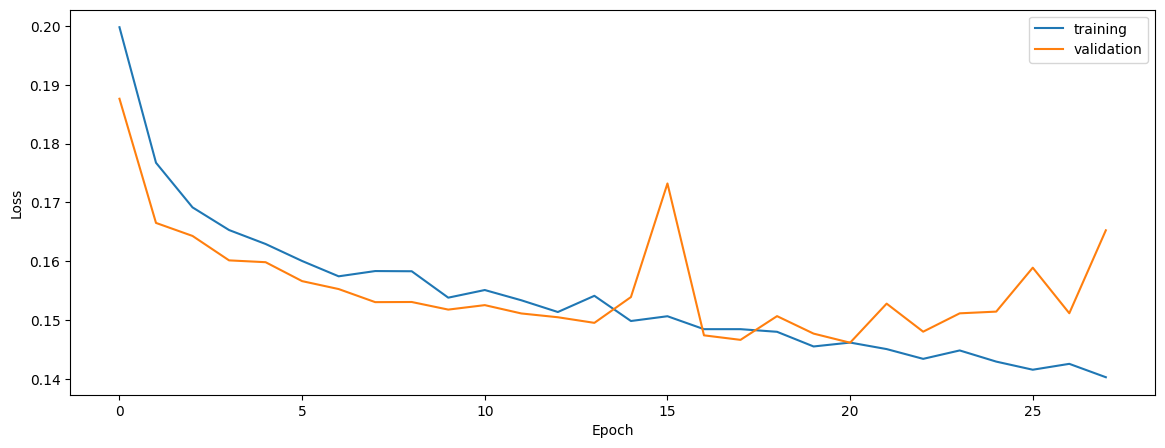

In [12]:
history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [13]:
props2 = props
model2 = model

In [14]:
import numpy as np

def getTrue(threshold):
    props=props1.copy()
    props['threshold'] = threshold
    props['radiomics'] = []
    props['radiomics_vox'] = [{'im':'t1','fe':['k5_b25']}]
    props['balance_data'] = False
    props['include_warp'] = True
    gen = DataGenerator(**props)
    return gen

def getPred(threshold, cla, reg):
    reg = reg[:,0]
    pred = cla.copy()
    pred[:,-1] = np.where(reg < threshold, 1, 0)
    for i in range(cla.shape[-1]-1):
        pred[:,i] = np.where(reg < threshold, 0, pred[:,i])
    return pred

In [15]:
from util import getAccuarcy, predictInBatches

props1['balance_data'] = False
props2['balance_data'] = False
gen1 = DataGenerator(**props1)
gen2 = DataGenerator(**props2)
train1, val1, test1 = gen1.getData()
train2, val2, test2 = gen2.getData()

train_cla = predictInBatches(model1,train1[0],architecture['batch_size'])
val_cla = predictInBatches(model1,val1[0],architecture['batch_size'])
test_cla = predictInBatches(model1,test1[0],architecture['batch_size'])
train_reg = predictInBatches(model2,train2[0],architecture['batch_size'])
val_reg = predictInBatches(model2,val2[0],architecture['batch_size'])
test_reg = predictInBatches(model2,test2[0],architecture['batch_size'])

threshold = props['threshold']

gen = getTrue(threshold)
train_true, val_true, test_true = gen.getData()
train_pred = getPred(threshold, train_cla, train_reg)
val_pred = getPred(threshold, val_cla, val_reg)
test_pred = getPred(threshold, test_cla, test_reg)

print('native')
print(getAccuarcy(train_true[1],train_pred))
print(getAccuarcy(val_true[1],val_pred))
print(getAccuarcy(test_true[1],test_pred))

native
0.6545714503004031
0.6655550774526678
0.5932987216962611


In [16]:
print('normalized')
print(getAccuarcy(train_true[1][train_true[2]],train_pred[train_true[2]]))
print(getAccuarcy(val_true[1][val_true[2]],val_pred[val_true[2]]))
print(getAccuarcy(test_true[1][test_true[2]],test_pred[test_true[2]]))

normalized
0.6511976434717449
0.6580481901199252
0.5989198408186469


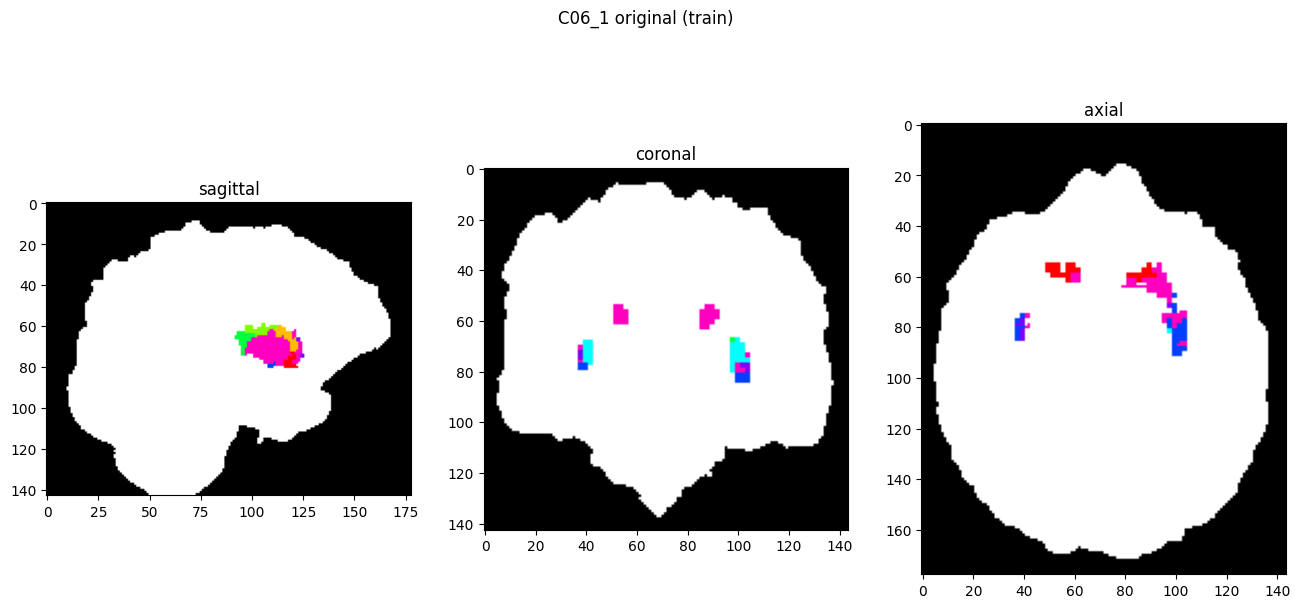

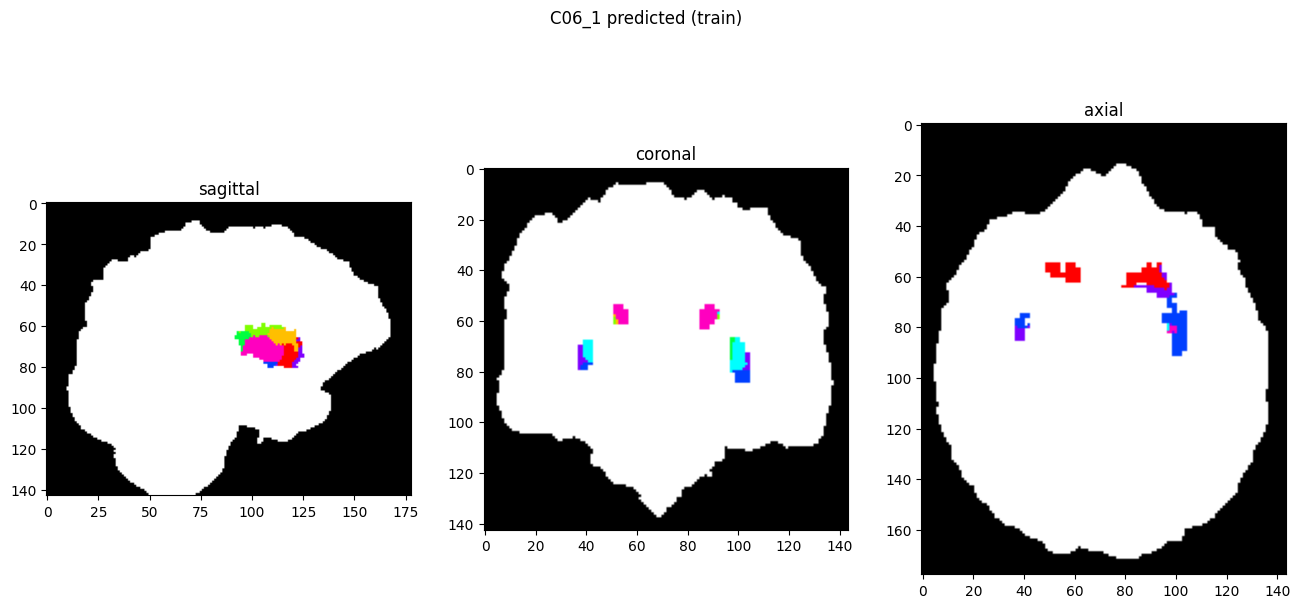

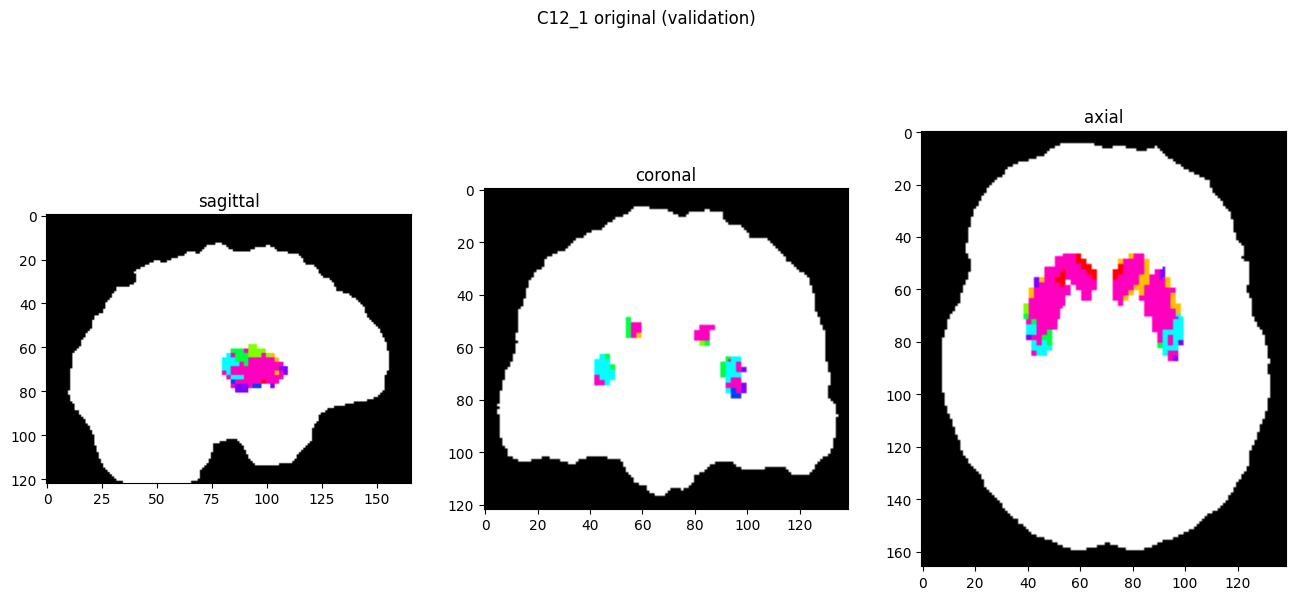

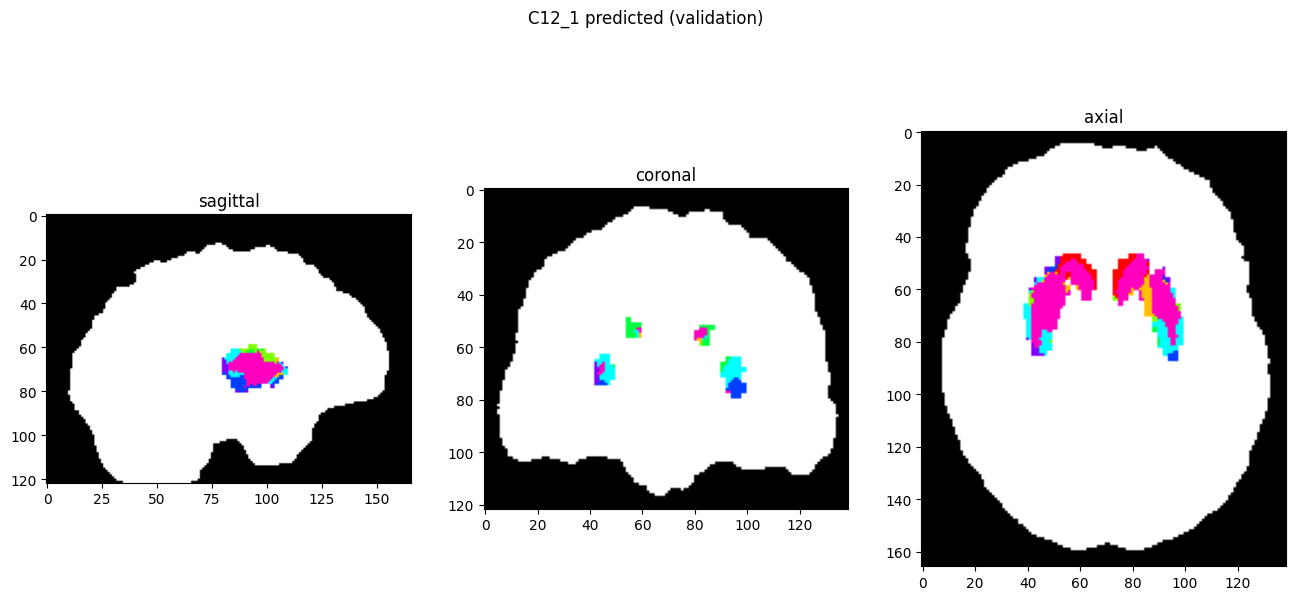

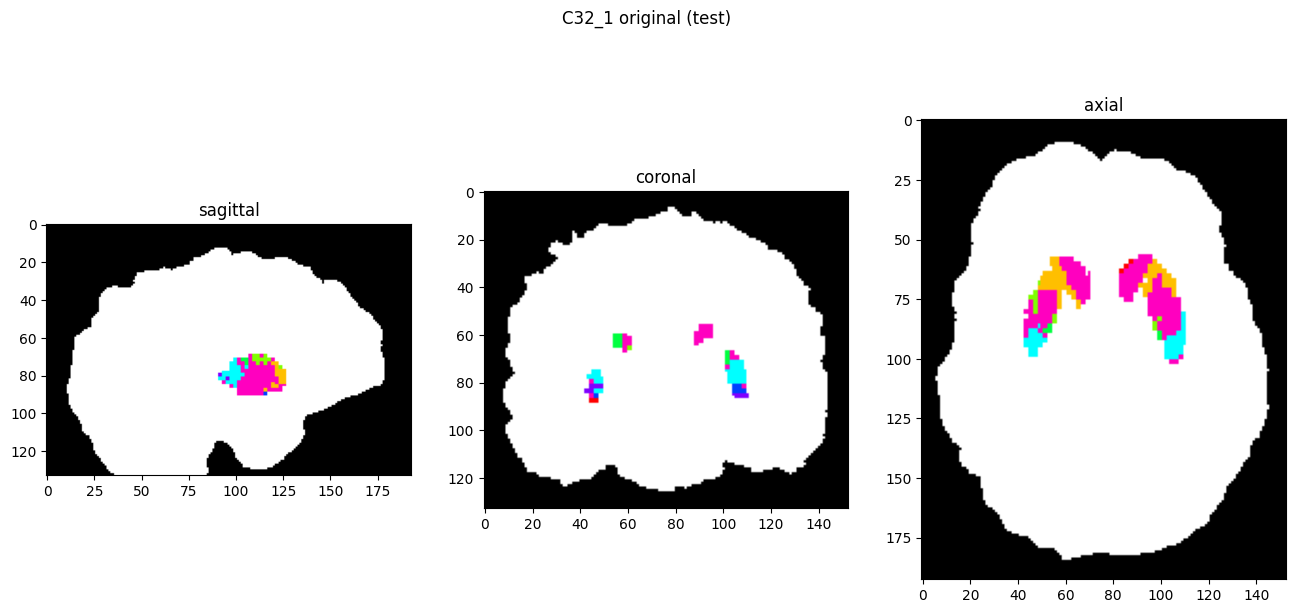

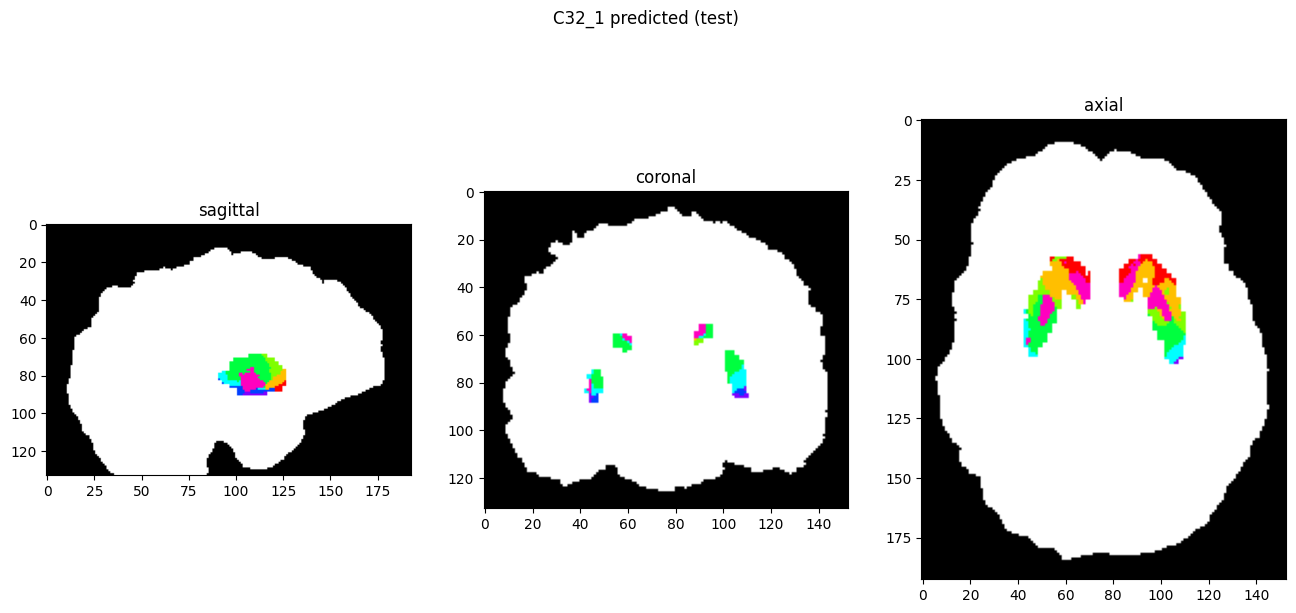

In [17]:
def customPredict(mode):
    idx = {'train':0,'validation':1,'test':2}[mode]
    dat_cla = gen1.getReconstructor(gen1.names[idx][0])
    dat_reg = gen2.getReconstructor(gen2.names[idx][0])
    pred_cla = predictInBatches(model1,dat_cla[0],architecture['batch_size'])
    pred_reg = predictInBatches(model2,dat_reg[0],architecture['batch_size'])
    return getPred(threshold, pred_cla, pred_reg)

showResults(model, gen, threshold=0, predict=customPredict)